# Домашнее задание 3

## 0. Введение

Проблемой короновируса COVID-19 буквально сейчас заняты многие ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые пытаются не просто предсказать развитие пандемии, а помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данной домашней работе Вы будете использовать ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного харатера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за домашнее задание. Не болейте!

In [ ]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 1s (146 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1b

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.api as sma
import statsmodels.formula.api as smf
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('time-series-19-covid-combined.csv')
df.tail()

Date Country/Region Province/State  ...  Confirmed  Recovered  Deaths
27393  2020-04-29       Zimbabwe            NaN  ...      32.00       5.00    4.00
27394  2020-04-30       Zimbabwe            NaN  ...      40.00       5.00    4.00
27395  2020-05-01       Zimbabwe            NaN  ...      40.00       5.00    4.00
27396  2020-05-02       Zimbabwe            NaN  ...      34.00       5.00    4.00
27397  2020-05-03       Zimbabwe            NaN  ...      34.00       5.00    4.00

[5 rows x 8 columns]

## 1. Exploratory data analysis

#### 1.1 Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни.

In [ ]:
print("Первый день исследуемого периода: ",df.Date.min(),
      "\nПоследний день исследуемого периода: ",df.Date.max(), 
      "\nКоличество заболевших: ", df.loc[df.Date==df.Date.max()]["Confirmed"].sum(),
      "\nКоличество погибших: ", df.loc[df.Date==df.Date.max()]["Deaths"].sum(), 
      "\nКоличество выздоровивших: ", df.loc[df.Date==df.Date.max()]["Recovered"].sum()) 

Первый день исследуемого периода:  2020-01-22 
Последний день исследуемого периода:  2020-05-03 
Количество заболевших:  3506729.0 
Количество погибших:  247470.0 
Количество выздоровивших:  1125236.0


In [ ]:
from itertools import chain

def draw_map(m, scale=0.2):
    # draw a shaded-relief image

    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

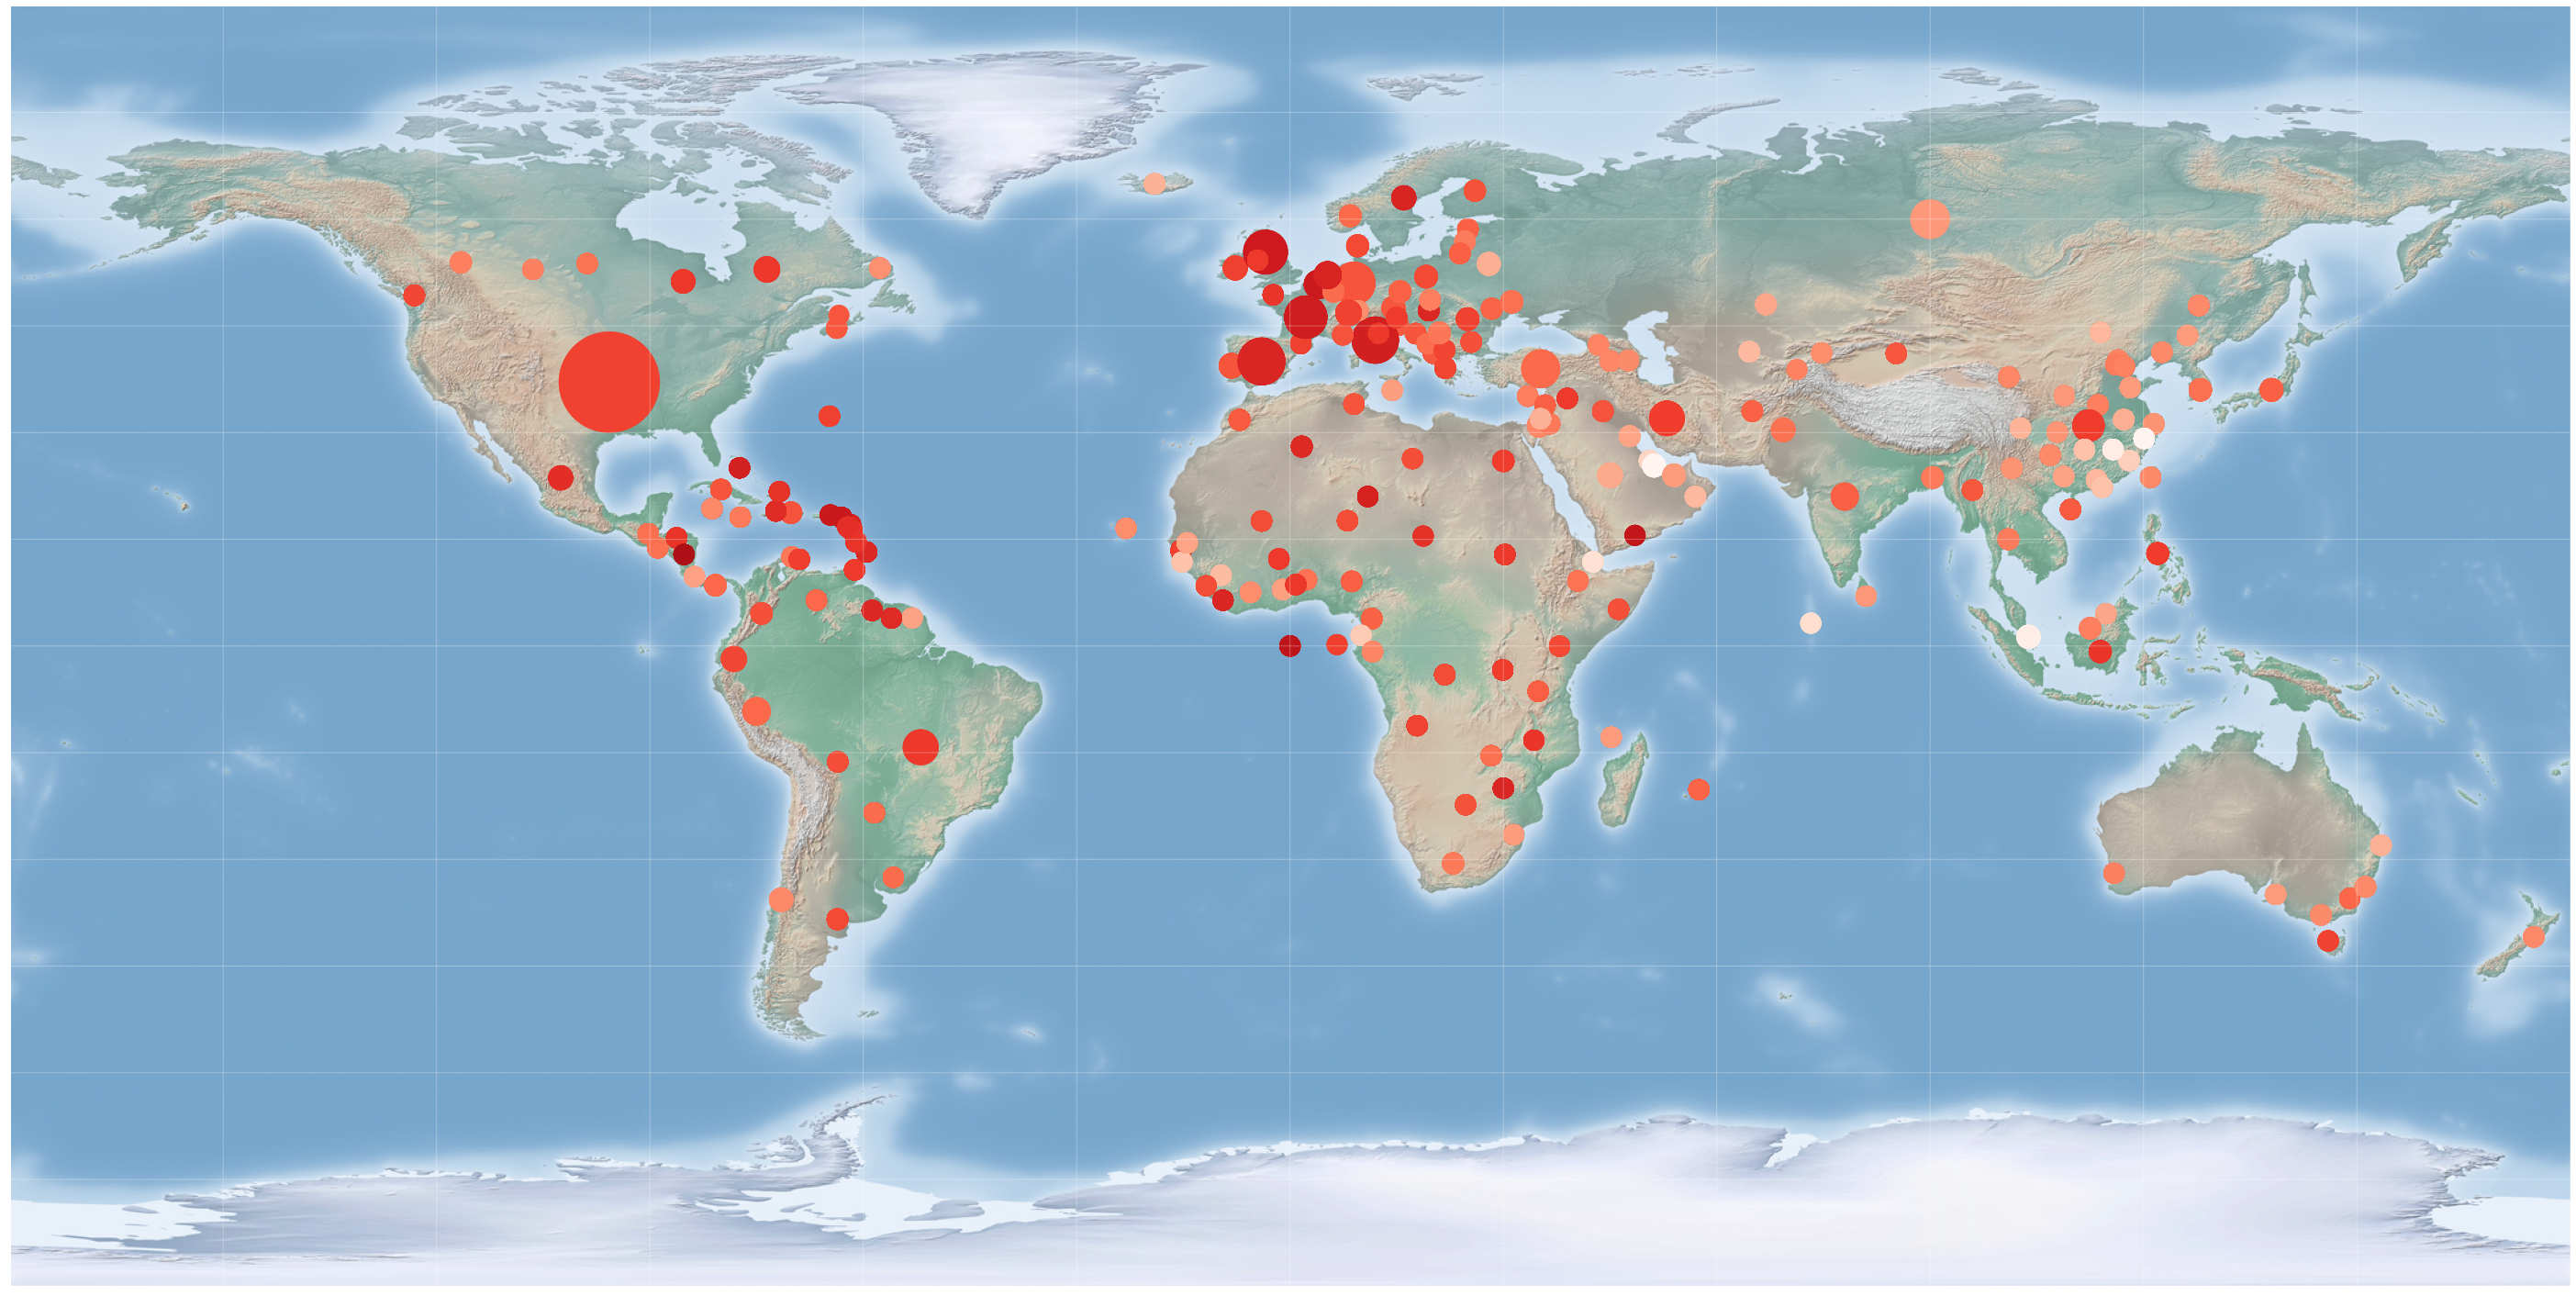

In [ ]:
# 1. Draw the map background
fig = plt.figure(figsize=(50, 30), edgecolor='None')
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
draw_map(m)

# 2. scatter city data, with color reflecting CFR
# and size reflecting confirmed
m.scatter(np.array(df.Long), np.array(df.Lat), latlon=True,
          c=(np.log10(np.array(df.Deaths/df.Confirmed))), s=500+np.array(df.Confirmed/100),
          cmap='Reds')


Размеры кружочков пропорциональны количеству заболевших, чем темнее кружочек тем выше летальность для данной страны/региона.

#### 1.2 Определите количество стран, которые подтвердили случаи заражения. Визуализируйте рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [ ]:
print("Количество стран, подтвердивших случаи заражения: ",len(np.unique(df.loc[df["Confirmed"] != 0]["Country/Region"])))

Количество стран, подтвердивших случаи заражения:  187


In [ ]:
c=[]
for i in range(len(df.Date.unique())):
    c.append(len(df.loc[df["Confirmed"] != 0].groupby("Date")["Country/Region"].unique()[i]))

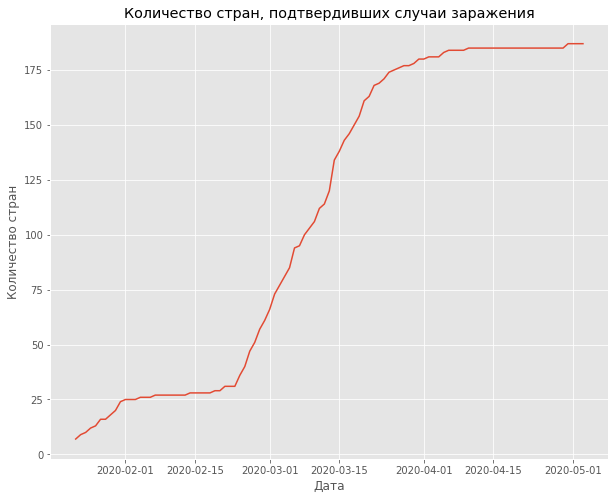

In [ ]:
df.Date = pd.DatetimeIndex(df.Date)
plt.figure(figsize=(10, 8))
plt.title("Количество стран, подтвердивших случаи заражения")
plt.xlabel("Дата")
plt.ylabel("Количество стран")
plt.plot(df.Date.unique(), c)

#### 1.3 Визуализируйте мировые тренды по числу заболевших | погибших | выздоровивших. Постройте графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

In [ ]:
df.groupby("Date")["Recovered"].sum()

Date
2020-01-22        28.00
2020-01-23        30.00
2020-01-24        36.00
2020-01-25        39.00
2020-01-26        52.00
                ...    
2020-04-29    948425.00
2020-04-30   1013871.00
2020-05-01   1052415.00
2020-05-02   1093112.00
2020-05-03   1125236.00
Name: Recovered, Length: 103, dtype: float64

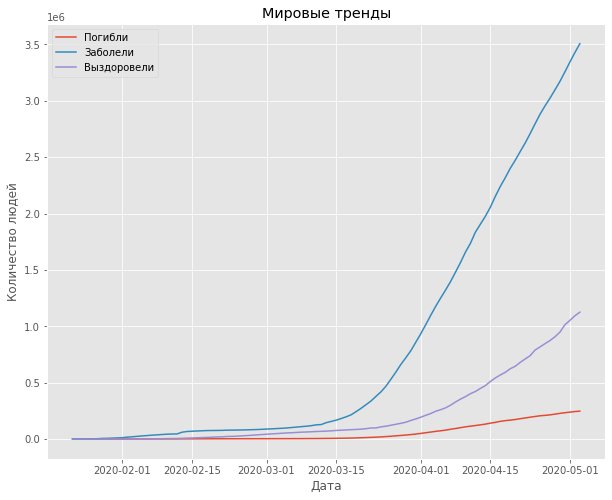

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(df.Date.unique(), df.groupby("Date")["Deaths"].sum(), label="Погибли")
plt.plot(df.Date.unique(), df.groupby("Date")['Confirmed'].sum(), label="Заболели")
plt.plot(df.Date.unique(), df.groupby("Date")["Recovered"].sum(), label="Выздоровели")
plt.title('Мировые тренды')
plt.ylabel('Количество людей')
plt.xlabel('Дата')
plt.legend(loc='upper left')

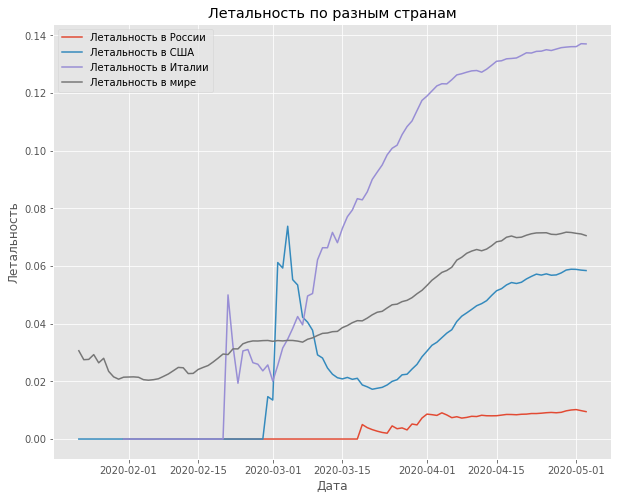

In [ ]:
df['CFR']=df['Deaths']/df['Confirmed']
#Рассмотрим летальность для некоторых стран
plt.figure(figsize=(10, 8))
plt.plot(df.Date.unique(), df.loc[df["Country/Region"]=='Russia']["CFR"], label="Летальность в России")
plt.plot(df.Date.unique(), df.loc[df["Country/Region"]=='US']["CFR"], label="Летальность в США")
plt.plot(df.Date.unique(), df.loc[df["Country/Region"]=='Italy']["CFR"], label="Летальность в Италии")
plt.plot(df.Date.unique(), df.groupby("Date")["Deaths"].sum()/df.groupby("Date")['Confirmed'].sum(), label="Летальность в мире")
plt.title('Летальность по разным странам')
plt.ylabel('Летальность')
plt.xlabel('Дата')
plt.legend(loc='upper left')

Летальность в разных страннах изменялась по разному. Для многих стран характерно резкое увеличение после выявления первых случаев заболевания.

#### 1.4 Визуализируйте и сравните, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая.

In [ ]:
from ipywidgets import interact, IntSlider, fixed, FloatSlider

Визуализируем распространение болезни по странам.

In [ ]:
#Функция для динамического изображения распростронения болезни
def raspr(day=1):
    date=df.Date.unique()
    fig = plt.figure(figsize=(10, 6), edgecolor='None')
    m = Basemap(projection='cyl', resolution=None,
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180, )
    draw_map(m)
    # 2. scatter city data, with color reflecting population
    # and size reflecting area
    r = [20 for _ in range(len(np.array(df.loc[(df["Date"] == date[day-1]) & (df["Confirmed"] != 0)])))]
    m.scatter(np.array(df.loc[(df["Date"] == date[day-1]) & (df["Confirmed"] != 0)]["Long"]), np.array(df.loc[(df["Date"] == date[day-1]) & (df["Confirmed"] != 0)]["Lat"]), latlon=True,
              color='r', s=r,
              cmap='Reds')



In [ ]:
interact(raspr, day=IntSlider(min=1,max=len(df.Date.unique()), step=1))

interactive(children=(IntSlider(value=1, description='day', max=103, min=1), Output()), _dom_classes=('widget-…

<function __main__.raspr>

Болезнь распростанялась достаточно не последовательно. Есть дни с резким увеличением стран с подтвержденными случаями. Сначала болезнь распространялась вокруг первых точек возникновения. Но потом точки стали появляться в удаленных участках, что скорее всего связано с перелетами людей на самолетах и прочих передвижениях.

In [ ]:
conf=df.loc[df["Confirmed"] != 0].groupby("Country/Region")["Date"].min()

In [ ]:
conf=pd.DataFrame(conf)

In [ ]:
conf["FirstDate"]=conf["Date"]
conf=conf.drop(['Date'], 1)

In [ ]:
conf["DSC"]=df.Date.max()-conf["FirstDate"]

In [ ]:
conf

FirstDate     DSC
Country/Region                       
Afghanistan        2020-02-24 69 days
Albania            2020-03-09 55 days
Algeria            2020-02-25 68 days
Andorra            2020-03-02 62 days
Angola             2020-03-20 44 days
...                       ...     ...
West Bank and Gaza 2020-03-05 59 days
Western Sahara     2020-04-05 28 days
Yemen              2020-04-10 23 days
Zambia             2020-03-18 46 days
Zimbabwe           2020-03-20 44 days

[187 rows x 2 columns]

Время с первого подтвержденного случая приведено на 3 мая.

#### 1.5 Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром.

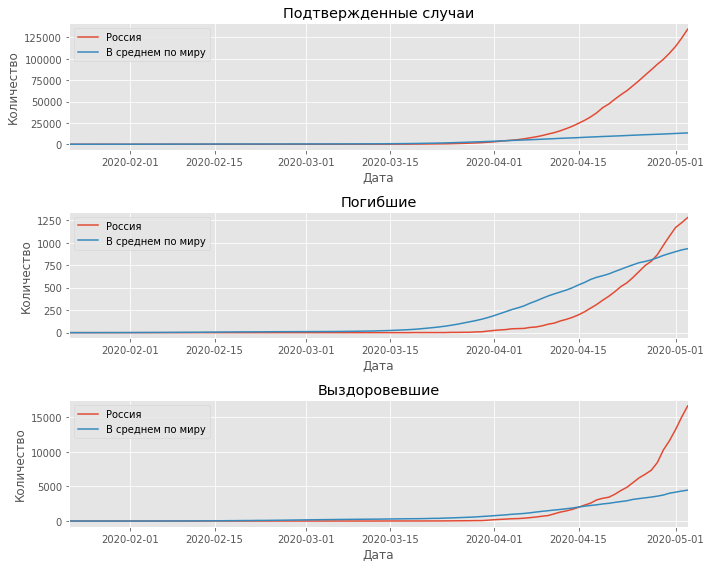

In [ ]:
fig, ((ax1), (ax2), (ax3)) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
ax1.plot(df.Date.unique(), df.loc[df["Country/Region"]=='Russia']["Confirmed"], label="Россия")
ax2.plot(df.Date.unique(), df.loc[df["Country/Region"]=='Russia']["Deaths"], label="Россия")
ax3.plot(df.Date.unique(), df.loc[df["Country/Region"]=='Russia']["Recovered"], label="Россия")
ax1.plot(df.Date.unique(), df.groupby("Date")["Confirmed"].mean(), label="В среднем по миру")
ax2.plot(df.Date.unique(), df.groupby("Date")["Deaths"].mean(), label="В среднем по миру")
ax3.plot(df.Date.unique(), df.groupby("Date")["Recovered"].mean(), label="В среднем по миру")
ax1.set_title('Подтвержденные случаи')
ax1.legend(loc='upper left')
ax1.set_ylabel('Количество')
ax1.set_xlabel('Дата')
ax1.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())

ax2.set_title('Погибшие')
ax2.legend(loc='upper left')
ax2.set_ylabel('Количество')
ax2.set_xlabel('Дата')
ax2.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())

ax3.set_title('Выздоровевшие')
ax3.legend(loc='upper left')
ax3.set_ylabel('Количество')
ax3.set_xlabel('Дата')
ax3.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())
fig.tight_layout()
 
plt.show()

Подтвержденных случаев в России меньше, чем в среднем по миру, одной из причин этого может быть меньшая численность населения других стран в целом. Аналогичная ситуация и с выздоровевшими. Количество погибших сначала было меньше среднего, но начало возрастать. Это может быть связаннос умалчиванием истинного числа смертей, или с более низким средним возрастом жителей страны (чем в странах Европы), следовательно болезнь может протекать легче. В таком случае резкий рост смертности мог возникнуть из-за нехватки апппаратуры, при постепенном заполнении больниц.

#### 1.6 Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравните насколько быстро развивается ситуация в этих странах, определите корреляцию.

In [ ]:
import seaborn as sns

In [ ]:
data=df.loc[(df["Date"] == df.Date.max())].groupby("Country/Region").sum().drop(['Lat', 'Long'], 1)

In [ ]:
DeathsTop10=data.sort_values('Deaths', ascending = 0).drop(['Recovered', 'Confirmed'], 1).head(10)

In [ ]:
DeathsTop10

Deaths  CFR
Country/Region              
US             67682.00 0.06
Italy          28884.00 0.14
United Kingdom 28520.00 0.71
Spain          25264.00 0.12
France         24900.00 0.40
Belgium         7844.00 0.16
Brazil          7051.00 0.07
Germany         6866.00 0.04
Iran            6203.00 0.06
Netherlands     5072.00 0.38

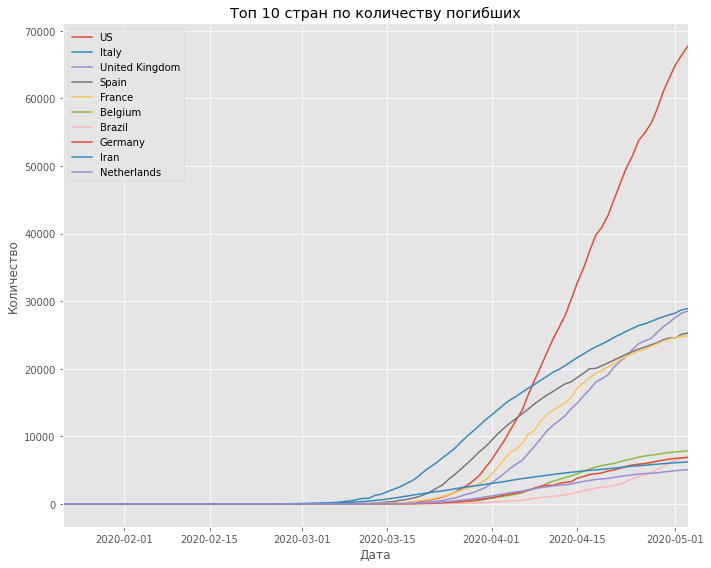

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

for name in DeathsTop10.index:
    ax.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["Deaths"].sum(), label=name)

ax.set_title('Топ 10 стран по количеству погибших')
ax.legend(loc='upper left')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
ax.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())
fig.tight_layout()
 
plt.show()

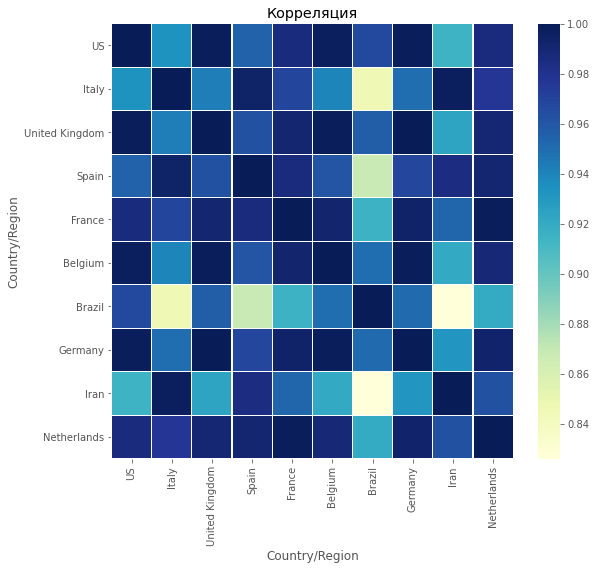

In [ ]:
data1=pd.DataFrame(columns=DeathsTop10.index)
for name in DeathsTop10.index:
    data1[name]=df.loc[df["Country/Region"]==name].groupby("Date")["Deaths"].sum()
corrmat = data1.corr()
f, ax = plt.subplots(figsize =(9, 8))
ax.set_title('Корреляция')
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [ ]:
corrmat

Country/Region   US  Italy  United Kingdom  ...  Germany  Iran  Netherlands
Country/Region                              ...                            
US             1.00   0.93            1.00  ...     1.00  0.91         0.99
Italy          0.93   1.00            0.94  ...     0.95  1.00         0.98
United Kingdom 1.00   0.94            1.00  ...     1.00  0.92         0.99
Spain          0.95   0.99            0.96  ...     0.97  0.98         0.99
France         0.99   0.97            0.99  ...     0.99  0.95         1.00
Belgium        1.00   0.94            1.00  ...     1.00  0.92         0.99
Brazil         0.97   0.85            0.96  ...     0.95  0.83         0.92
Germany        1.00   0.95            1.00  ...     1.00  0.93         0.99
Iran           0.91   1.00            0.92  ...     0.93  1.00         0.96
Netherlands    0.99   0.98            0.99  ...     0.99  0.96         1.00

[10 rows x 10 columns]

Для данного топа можно заметить, что корреляция данных Бразилии с другими странами чуть ниже, но это можно вполне вписать в погрешность. Из графиков видно, что странны в целом можно разделить на три группы. Страны этих групп отличаются численностью и плотностью населения (возможно уровень урбанизации в странах с большим числом заразившихся тоже чуть выше).

In [ ]:
ConfirmedTop10=data.sort_values('Confirmed', ascending = 0).drop(['Recovered', 'Deaths'], 1).head(10)

In [ ]:
ConfirmedTop10

Confirmed  CFR
Country/Region                
US             1158040.00 0.06
Spain           217466.00 0.12
Italy           210717.00 0.14
United Kingdom  187842.00 0.71
France          168925.00 0.40
Germany         165664.00 0.04
Russia          134687.00 0.01
Turkey          126045.00 0.03
Brazil          101826.00 0.07
Iran             97424.00 0.06

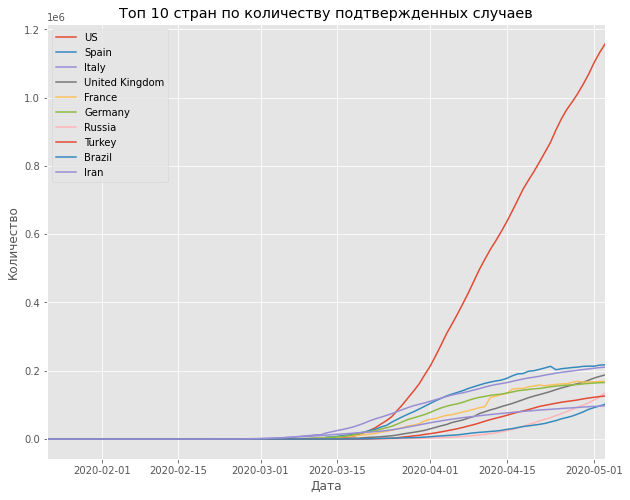

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
for name in ConfirmedTop10.index:
    ax.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["Confirmed"].sum(), label=name)
ax.set_title('Топ 10 стран по количеству подтвержденных случаев')
ax.legend(loc='upper left')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
ax.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())
plt.show()

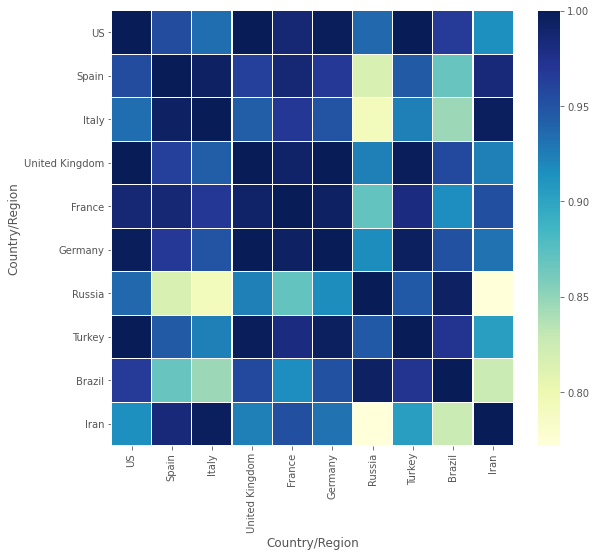

In [ ]:
data1=pd.DataFrame(columns=ConfirmedTop10.index)
for name in ConfirmedTop10.index:
    data1[name]=df.loc[df["Country/Region"]==name].groupby("Date")["Deaths"].sum()
corrmat = data1.corr()
ax.set_title('Корреляция')
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [ ]:
corrmat

Country/Region   US  Spain  Italy  United Kingdom  ...  Russia  Turkey  Brazil  Iran
Country/Region                                     ...                              
US             1.00   0.95   0.93            1.00  ...    0.94    1.00    0.97  0.91
Spain          0.95   1.00   0.99            0.96  ...    0.82    0.95    0.87  0.98
Italy          0.93   0.99   1.00            0.94  ...    0.79    0.92    0.85  1.00
United Kingdom 1.00   0.96   0.94            1.00  ...    0.92    1.00    0.96  0.92
France         0.99   0.99   0.97            0.99  ...    0.87    0.98    0.92  0.95
Germany        1.00   0.97   0.95            1.00  ...    0.92    1.00    0.95  0.93
Russia         0.94   0.82   0.79            0.92  ...    1.00    0.95    0.99  0.77
Turkey         1.00   0.95   0.92            1.00  ...    0.95    1.00    0.97  0.90
Brazil         0.97   0.87   0.85            0.96  ...    0.99    0.97    1.00  0.83
Iran           0.91   0.98   1.00            0.92  ...    0.77    0.90    0.83  1.00

[10 rows x 10 columns]

Ситуация в целом похожа на прошлый топ. В данном случае корреляция по данным ниже у России. Значительно отличается график США. Скорее всего это связано с численностью населения и менталитете жителей. В то время как в нашей стране не принято ходить к врачам, в Сша посещают медицинские учреждения значительно чаще.

In [ ]:
RecoveredTop10=data.sort_values('Recovered', ascending = 0).drop(['Deaths', 'Confirmed'], 1).head(10)

In [ ]:
RecoveredTop10

Recovered  CFR
Country/Region                
US              180152.00 0.06
Germany         130600.00 0.04
Spain           118902.00 0.12
Italy            81654.00 0.14
China            78684.00 0.36
Iran             78422.00 0.06
Turkey           63151.00 0.03
France           50885.00 0.40
Brazil           42991.00 0.07
Canada           24921.00 1.30

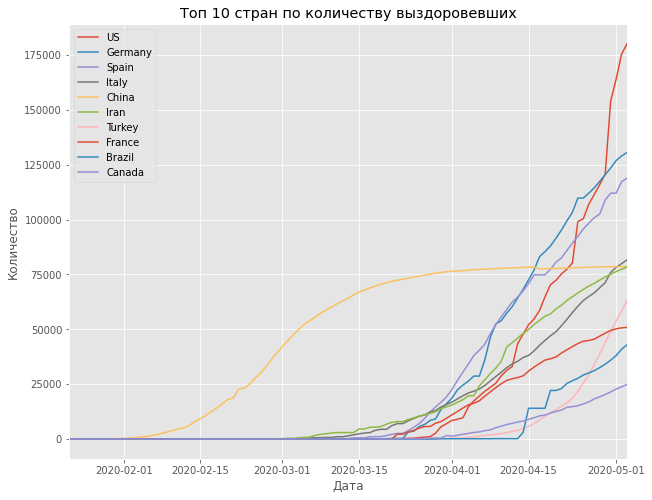

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
for name in RecoveredTop10.index:
    ax.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["Recovered"].sum(), label=name)

ax.set_title('Топ 10 стран по количеству выздоровевших')
ax.legend(loc='upper left')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
ax.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())
 
plt.show()

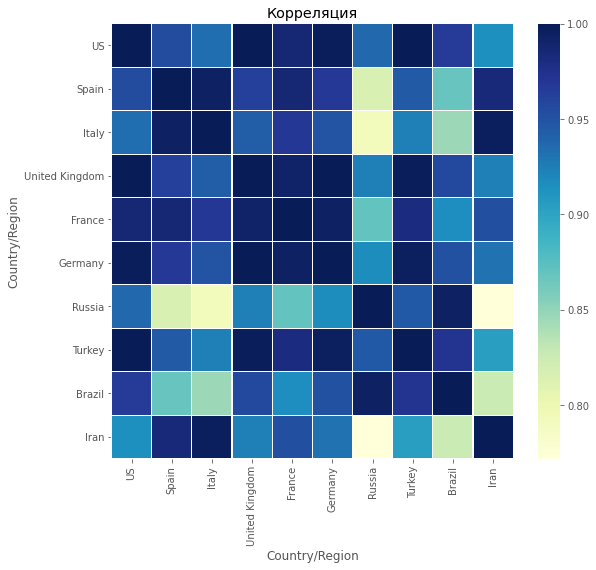

In [ ]:
data1=pd.DataFrame(columns=ConfirmedTop10.index)
for name in ConfirmedTop10.index:
    data1[name]=df.loc[df["Country/Region"]==name].groupby("Date")["Deaths"].sum()
corrmat = data1.corr()
f, ax = plt.subplots(figsize =(9, 8))
ax.set_title('Корреляция')
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [ ]:
corrmat

Country/Region   US  Spain  Italy  United Kingdom  ...  Russia  Turkey  Brazil  Iran
Country/Region                                     ...                              
US             1.00   0.95   0.93            1.00  ...    0.94    1.00    0.97  0.91
Spain          0.95   1.00   0.99            0.96  ...    0.82    0.95    0.87  0.98
Italy          0.93   0.99   1.00            0.94  ...    0.79    0.92    0.85  1.00
United Kingdom 1.00   0.96   0.94            1.00  ...    0.92    1.00    0.96  0.92
France         0.99   0.99   0.97            0.99  ...    0.87    0.98    0.92  0.95
Germany        1.00   0.97   0.95            1.00  ...    0.92    1.00    0.95  0.93
Russia         0.94   0.82   0.79            0.92  ...    1.00    0.95    0.99  0.77
Turkey         1.00   0.95   0.92            1.00  ...    0.95    1.00    0.97  0.90
Brazil         0.97   0.87   0.85            0.96  ...    0.99    0.97    1.00  0.83
Iran           0.91   0.98   1.00            0.92  ...    0.77    0.90    0.83  1.00

[10 rows x 10 columns]

Корреляция России опять ниже почему это может быть в случае с выздоровевшими рассмотрено выше. Выделяется график Китая. В целом ситуация в Китае отличается от мира, так как болезнь там началась раньше, так же сильное влияние конкретно на данный пункт мого оказать ответственное отношение жителей страны, несмотря на высокую численность аселения болезнь удалось остановить поэтому данные перестали меняться значительно.

1.7 Для первых 5 стран из топ-10 и России постойте сравнительные графики. Изучите как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей, ваш вариант...

Загрузим данные по численности и плотности населеления из датасета: [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020).

In [ ]:
new = pd.read_csv('population_by_country_2020.csv')
new['Country (or dependency)']=new['Country (or dependency)'].replace('United States','US')

In [ ]:
new

Country (or dependency)  Population (2020)  ... Urban Pop %  World Share
0                     China         1438207241  ...        61 %      18.47 %
1                     India         1377233523  ...        35 %      17.70 %
2                        US          330610570  ...        83 %       4.25 %
3                 Indonesia          272931713  ...        56 %       3.51 %
4                  Pakistan          219992900  ...        35 %       2.83 %
..                      ...                ...  ...         ...          ...
230              Montserrat               4991  ...        10 %       0.00 %
231        Falkland Islands               3458  ...        66 %       0.00 %
232                    Niue               1624  ...        46 %       0.00 %
233                 Tokelau               1354  ...         0 %       0.00 %
234                Holy See                801  ...        N.A.       0.00 %

[235 rows x 11 columns]

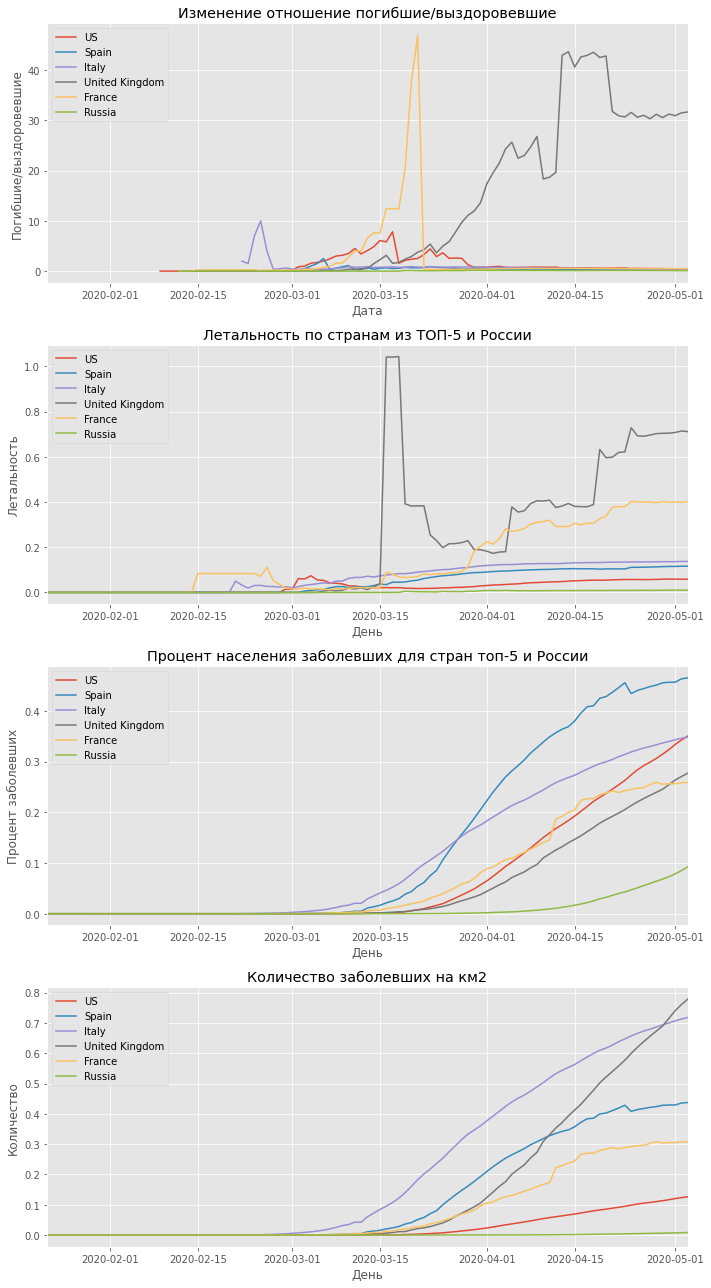

In [ ]:
fig, ((ax1), (ax2), (ax3), (ax4)) = plt.subplots(nrows=4, ncols=1, figsize=(10, 18))
Top5=data.sort_values('Confirmed', ascending = 0).head(5)
listTop6=np.array(Top5.index)
listTop6=np.append(listTop6,"Russia")
for name in listTop6:
    ax2.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["CFR"].sum(), label=name)
    ax1.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["Deaths"].sum()/df.loc[df["Country/Region"]==name].groupby("Date")["Recovered"].sum(), label=name)
    ax3.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["Confirmed"].sum()/new.loc[new["Country (or dependency)"]==name]["Population (2020)"].sum()*100, label=name)
    ax4.plot(df["Date"].unique(), df.loc[df["Country/Region"]==name].groupby("Date")["Confirmed"].sum()/new.loc[new["Country (or dependency)"]==name]["Population (2020)"].sum()*new.loc[new["Country (or dependency)"]==name]["Density (P/Km²)"].sum(), label=name)
   
ax1.set_title('Изменение отношение погибшие/выздоровевшие')
ax1.legend(loc='upper left')
ax1.set_ylabel('Погибшие/выздоровевшие')
ax1.set_xlabel('Дата')
ax1.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())

ax2.set_title('Летальность по странам из ТОП-5 и России')
ax2.legend(loc='upper left')
ax2.set_ylabel('Летальность')
ax2.set_xlabel('День')
ax2.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())

ax3.set_title('Процент населения заболевших для стран топ-5 и России')
ax3.legend(loc='upper left')
ax3.set_ylabel('Процент заболевших')
ax3.set_xlabel('День')
ax3.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())

ax4.set_title('Количество заболевших на км2')
ax4.set_ylabel('Количество')
ax4.set_xlabel('День')
ax4.set_xlim(xmin=df.Date.min() , xmax=df.Date.max())
ax4.legend(loc='upper left')
fig.tight_layout()
 
plt.show()

Из необычного здесь можно заметить очень странное и не стабильное поведение летальности в Великобритании. А так же странности в отношении погибшие/выздоровевшие для Франции, но никаких ошибок или некорректности данных я не обнаружила..

1.8 Выделите временной ряд по одному из целевых признаков. Для выделенного временного ряда:
  - Представьте временной ряд в виде последовательности разницы между значениями. Рассчитайте лаги, выведите их на графике.
  - Попробуйте декомпозировать временной ряд. Постройте график тренда.
  - Что вы можете сказать о стационарности временного ряда? 

Выделям временной ряд по смертям для России.

In [ ]:
dfRussia= df[df["Country/Region"]=='Russia']

In [ ]:
dfRussia.Date = pd.DatetimeIndex(dfRussia.Date)
dfRussia.index = pd.PeriodIndex(dfRussia.Date, freq='D')

In [ ]:
dfRussia

Date Country/Region Province/State  ...  Recovered  Deaths  CFR
Date                                                 ...                        
2020-01-22 2020-01-22         Russia            NaN  ...       0.00    0.00  nan
2020-01-23 2020-01-23         Russia            NaN  ...       0.00    0.00  nan
2020-01-24 2020-01-24         Russia            NaN  ...       0.00    0.00  nan
2020-01-25 2020-01-25         Russia            NaN  ...       0.00    0.00  nan
2020-01-26 2020-01-26         Russia            NaN  ...       0.00    0.00  nan
...               ...            ...            ...  ...        ...     ...  ...
2020-04-29 2020-04-29         Russia            NaN  ...   10286.00  972.00 0.01
2020-04-30 2020-04-30         Russia            NaN  ...   11619.00 1073.00 0.01
2020-05-01 2020-05-01         Russia            NaN  ...   13220.00 1169.00 0.01
2020-05-02 2020-05-02         Russia            NaN  ...   15013.00 1222.00 0.01
2020-05-03 2020-05-03         Russia            NaN  ...   16639.00 1280.00 0.01

[103 rows x 9 columns]

In [ ]:
# Рассчитаем для него лаги
dfRussia["DeathsShift1"] = dfRussia.Deaths.shift()

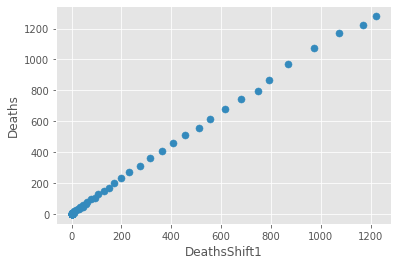

In [ ]:
dfRussia.plot(kind= "scatter", y = "Deaths", x = "DeathsShift1", s = 50)

Представим как разницу

In [ ]:
dfRussia["DeathsDiff"] = dfRussia.Deaths - dfRussia.DeathsShift1

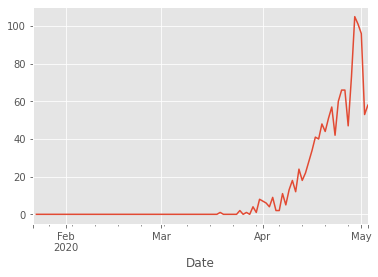

In [ ]:
dfRussia.DeathsDiff.plot()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
dfRussia.index = dfRussia.index.to_timestamp()

In [ ]:
decomposition = seasonal_decompose(dfRussia.Deaths, model = "additive")

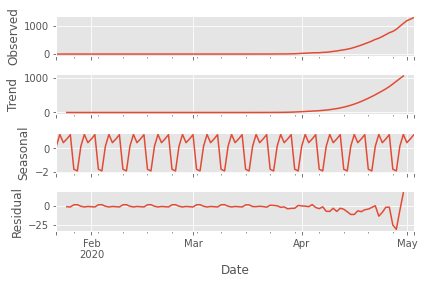

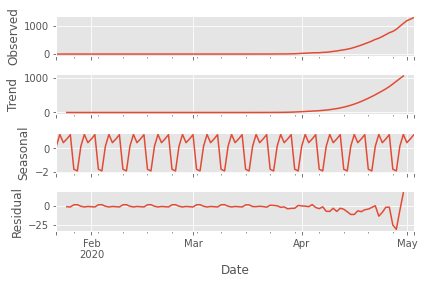

In [ ]:
decomposition.plot()


Выделим тренд

In [ ]:
trend = decomposition.trend

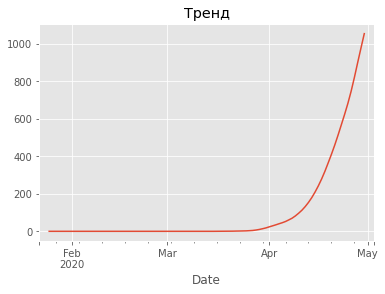

In [ ]:
plt.title("Тренд")
trend.plot()

In [ ]:
import statsmodels.api as sm

In [ ]:
test = sm.tsa.adfuller(dfRussia.Deaths)
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')


adf:  -4.265415408822304
p-value:  0.0005096235342701728
Critical values:  {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}
Единичных корней нет, ряд стационарен


1.9 Для любого интересующего Вас временного ряда постройте графики ACF и PACF. Сделайте выводы. 

Построим для этого же ряда графики.

In [ ]:
ts = dfRussia.Deaths
ts_diff = dfRussia.DeathsDiff
ts_diff.dropna(inplace = True)

In [ ]:
# ACF и PACF 
from statsmodels.tsa.stattools import acf, pacf

In [ ]:
lag_acf = acf(ts_diff, nlags=20)

In [ ]:
lag_acf

array([1.        , 0.93595537, 0.88082668, 0.80458042, 0.74319941,
       0.68217214, 0.62212   , 0.59278694, 0.54296751, 0.50419591,
       0.45363728, 0.41541346, 0.37684311, 0.32683619, 0.28722885,
       0.23814569, 0.19936951, 0.16365651, 0.13273574, 0.10940336,
       0.0807758 ])

In [ ]:
ACF = pd.Series(lag_acf)

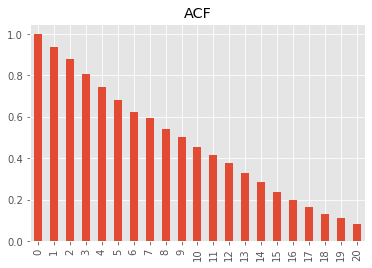

In [ ]:
plt.title("ACF")
ACF.plot(kind = "bar")

In [ ]:
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

In [ ]:
PACF = pd.Series(lag_pacf)

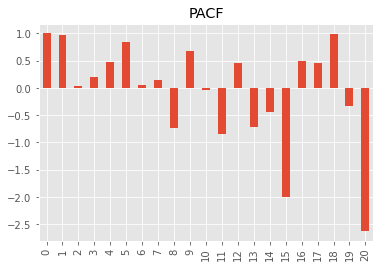

In [ ]:
plt.title("PACF")
PACF.plot(kind = "bar")

#### 1.10. Изучаемый Вами датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет, вы можете его использовать во второй части домашнего задания.
- Исследуйте как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [ ]:
conf= pd.DataFrame(df.loc[df["Confirmed"] != 0].groupby("Country/Region")["Date"].min())
conf["Country/Region"]=conf.index
conf['DateFirst']=conf.Date
conf=conf.drop(["Date"], 1)

In [ ]:
df=df.join(conf.set_index("Country/Region"),on="Country/Region")

In [ ]:
#количество дней со дня первого случая заражения
df["DSC"]=((df.Date-df["DateFirst"])/np.timedelta64(1, 'D')).round(0).astype(int)

In [ ]:
df

Date Country/Region Province/State  ...  CFR  DateFirst  DSC
0     2020-01-22    Afghanistan            NaN  ...  nan 2020-02-24  -33
1     2020-01-23    Afghanistan            NaN  ...  nan 2020-02-24  -32
2     2020-01-24    Afghanistan            NaN  ...  nan 2020-02-24  -31
3     2020-01-25    Afghanistan            NaN  ...  nan 2020-02-24  -30
4     2020-01-26    Afghanistan            NaN  ...  nan 2020-02-24  -29
...          ...            ...            ...  ...  ...        ...  ...
27393 2020-04-29       Zimbabwe            NaN  ... 0.12 2020-03-20   40
27394 2020-04-30       Zimbabwe            NaN  ... 0.10 2020-03-20   41
27395 2020-05-01       Zimbabwe            NaN  ... 0.10 2020-03-20   42
27396 2020-05-02       Zimbabwe            NaN  ... 0.12 2020-03-20   43
27397 2020-05-03       Zimbabwe            NaN  ... 0.12 2020-03-20   44

[27398 rows x 11 columns]

Еще раз загрузим использованый ранее датасет

In [ ]:
new = pd.read_csv('population_by_country_2020.csv')
new.tail()

Country (or dependency)  Population (2020)  ... Urban Pop %  World Share
230              Montserrat               4991  ...        10 %       0.00 %
231        Falkland Islands               3458  ...        66 %       0.00 %
232                    Niue               1624  ...        46 %       0.00 %
233                 Tokelau               1354  ...         0 %       0.00 %
234                Holy See                801  ...        N.A.       0.00 %

[5 rows x 11 columns]

Многие страны в данном датасете в названии имеют символы и сокращения не соответствующие нашим, заменим их.

In [ ]:
new['Country (or dependency)']=new['Country (or dependency)'].replace('United States','US')
new['Country (or dependency)']=new['Country (or dependency)'].replace('DR Congo','Congo (Kinshasa)')
new['Country (or dependency)']=new['Country (or dependency)'].replace('Congo','Congo (Brazzaville)')
new['Country (or dependency)']=new['Country (or dependency)'].replace('Czech Republic (Czechia)','Czechia')
new['Country (or dependency)']=new['Country (or dependency)'].replace("Côte d'Ivoire","Cote d'Ivoire")
new['Country (or dependency)']=new['Country (or dependency)'].replace("South Korea","Korea, South")
new['Country (or dependency)']=new['Country (or dependency)'].replace("Taiwan","Taiwan*")
new['Country (or dependency)']=new['Country (or dependency)'].replace("Sao Tome & Principe", "Sao Tome and Principe")
new['Country (or dependency)']=new['Country (or dependency)'].replace("St. Vincent & Grenadines","Saint Vincent and the Grenadines")
new['Country (or dependency)']=new['Country (or dependency)'].replace("Saint Kitts & Nevis", "Saint Kitts and Nevis")
new['Country (or dependency)']=new['Country (or dependency)'].replace("State of Palestine", "West Bank and Gaza")
new['Country (or dependency)']=new['Country (or dependency)'].replace("Myanmar", "Burma")


Видимо в данном датасете Косово не признано отдельное страной, добавим его заполнив необходимыми нам данными из интернета.

In [ ]:
new=new.append(pd.DataFrame([['Kosovo', 1907592, 176, -572, 26,"45 %"]], columns = ['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Migrants (net)','Med. Age', 'Urban Pop %']))

Удалим поля, которые нам не нужны.

In [ ]:
new=new.drop(['Land Area (Km²)','Fert. Rate','Yearly Change','Net Change','World Share'], 1)

In [ ]:
new

Country (or dependency)  Population (2020)  ...  Med. Age  Urban Pop %
0                     China         1438207241  ...        38         61 %
1                     India         1377233523  ...        28         35 %
2                        US          330610570  ...        38         83 %
3                 Indonesia          272931713  ...        30         56 %
4                  Pakistan          219992900  ...        23         35 %
..                      ...                ...  ...       ...          ...
231        Falkland Islands               3458  ...      N.A.         66 %
232                    Niue               1624  ...      N.A.         46 %
233                 Tokelau               1354  ...      N.A.          0 %
234                Holy See                801  ...      N.A.         N.A.
0                    Kosovo            1907592  ...        26         45 %

[236 rows x 6 columns]

Соединим таблицы.

In [ ]:
df=df.join(new.set_index("Country (or dependency)"),on="Country/Region")

In [ ]:
df

Date Country/Region  ... Med. Age  Urban Pop %
0     2020-01-22    Afghanistan  ...       18         25 %
1     2020-01-23    Afghanistan  ...       18         25 %
2     2020-01-24    Afghanistan  ...       18         25 %
3     2020-01-25    Afghanistan  ...       18         25 %
4     2020-01-26    Afghanistan  ...       18         25 %
...          ...            ...  ...      ...          ...
27393 2020-04-29       Zimbabwe  ...       19         38 %
27394 2020-04-30       Zimbabwe  ...       19         38 %
27395 2020-05-01       Zimbabwe  ...       19         38 %
27396 2020-05-02       Zimbabwe  ...       19         38 %
27397 2020-05-03       Zimbabwe  ...       19         38 %

[27398 rows x 16 columns]

Посмотри как влияют отобраные нами признаки на распространение болезни. Введем понятие скорость распространения: отношение кол-ва заболевших к времени прошедшему с первого подтвержденного случая. Найдем скорости для всех стран.

In [ ]:
speed=df.loc[df.Date==df.Date.max()].groupby("Country/Region")['Confirmed'].sum()/df.loc[df.Date==df.Date.max()].groupby("Country/Region")['DSC'].sum()

In [ ]:
speed

Country/Region
Afghanistan          39.19
Albania              14.45
Algeria              65.79
Andorra              12.06
Angola                0.80
                      ... 
West Bank and Gaza    5.98
Western Sahara        0.21
Yemen                 0.43
Zambia                2.70
Zimbabwe              0.77
Length: 187, dtype: float64

Для всех стран выпишим признаки.

In [ ]:
pop=df.loc[df.Date==df.Date.max()].groupby("Country/Region")['Population (2020)'].max()
age=df.loc[df.Date==df.Date.max()].groupby("Country/Region")['Med. Age'].max()
den=df.loc[df.Date==df.Date.max()].groupby("Country/Region")['Density (P/Km²)'].max()
migr=df.loc[df.Date==df.Date.max()].groupby("Country/Region")['Migrants (net)'].max()
urb=df.loc[df.Date==df.Date.max()].groupby("Country/Region")['Urban Pop %'].max()

In [ ]:
age=age.replace(["N.A.", np.nan], 30).astype(int)
migr=migr.replace([np.nan], 0)
urb=urb.replace(["N.A.", np.nan], "30 %")


In [ ]:
for i in urb.index:
    urb[i]=urb[i].replace(' %','')
urb=urb.astype(int)

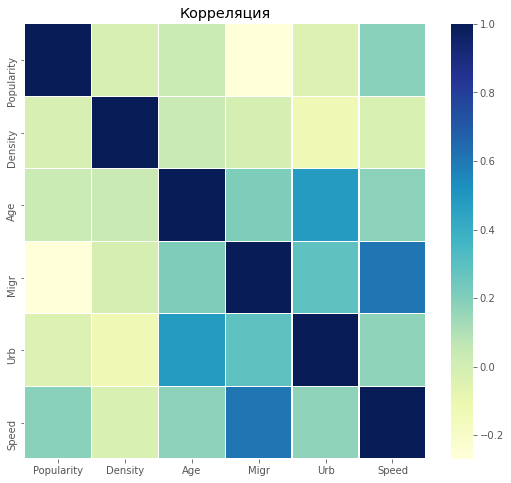

In [ ]:
data1={'Popularity':pop,
'Density' :den,   
'Age' :age, 
'Migr' :migr,  
'Urb': urb,
'Speed':speed,
}
data1=pd.DataFrame(data1)
corrmat = data1.corr()

f, ax = plt.subplots(figsize =(9, 8))
ax.set_title('Корреляция')
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [ ]:
corrmat

Popularity  Density  Age  Migr   Urb  Speed
Popularity        1.00    -0.02 0.03 -0.27 -0.04   0.18
Density          -0.02     1.00 0.04 -0.01 -0.13  -0.02
Age               0.03     0.04 1.00  0.21  0.48   0.18
Migr             -0.27    -0.01 0.21  1.00  0.29   0.61
Urb              -0.04    -0.13 0.48  0.29  1.00   0.17
Speed             0.18    -0.02 0.18  0.61  0.17   1.00

В целом эти признаки никак не влияют на скорость распространения. Однако на удивление признак отражающий количество мигрантов все таки довольно значим.

### 1.11 Выводы
В целом данные имеют некоторый тренд. Болезнь распростаняется быстро и ее распространение имеет характерные черты. Однако в некоторых случаях данные отличаются от ожидаемого поведения, так Китай как страна с первым зафиксированым случаем имеет довольно нехарактерные графики развития болезни. Также случаются и выбросы в данных. Значимых признаков влияющих на распространение выявлено не было.

## 2. Прогнозирование временного ряда

Теперь вам предстоит построить несколько моделей и спрогнозировать временной ряд для такого показателя как летальности от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

Метрика качества RMSE. Не забудьте разбить данные временной ряд на данные для обучения и тестовые.

Не забывайте сопровождать ваш код комментариями, графиками и выводами.

### 2.1 Прогнозирование средним (Mean Constant Model)

Выберем три страны. Пусть это будет Китай: для этой страны данных больше, так как болезнь началась раньше. США: страна лидирующая в нескольких топах. Россия: есть некоторые вопросы к данным, хотелось бы посмотреть как на них будет работать прогнозирование.

In [ ]:
countries=['Russia','US','China']

In [ ]:
df['CFRLog'] = np.log(df.CFR)

In [ ]:
date=df.iloc[(int)(len(df.groupby("Date"))*0.8)]["Date"] #определим дату, на котрой закнчиваются 80% данных

Разделим данные на test и train.

In [ ]:
train=pd.DataFrame(df.loc[(df["Date"]<date)].groupby("Date")["Date"].max(), columns=['Date'])
test=pd.DataFrame(df.loc[(df["Date"]>=date)].groupby("Date")["Date"].max(), columns=['Date'])
test.Date = pd.DatetimeIndex(test.Date)
test.index = pd.PeriodIndex(test.Date, freq='D')
train.Date = pd.DatetimeIndex(train.Date)
train.index = pd.PeriodIndex(train.Date, freq='D')


In [ ]:
for country in countries:
    log=country+'Log'
    train[country]=np.array(df.loc[(df["Country/Region"]==country) & (df["Date"]<date)].groupby("Date")["Deaths"].sum()/df.loc[(df["Country/Region"]==country) & (df["Date"]<date)].groupby("Date")["Confirmed"].sum())
    test[country]=np.array(df.loc[(df["Country/Region"]==country) & (df["Date"]>=date)].groupby("Date")["Deaths"].sum()/df.loc[(df["Country/Region"]==country) & (df["Date"]>=date)].groupby("Date")["Confirmed"].sum())
    test[log]=np.log(test[country])
    train[log]=np.log(train[country])


In [ ]:
data=pd.concat([train,test])

Полученные данные.

In [ ]:
data

Date  Russia  RussiaLog   US  USLog  China  ChinaLog
Date                                                                 
2020-01-22 2020-01-22     nan        nan 0.00   -inf   0.03     -3.47
2020-01-23 2020-01-23     nan        nan 0.00   -inf   0.03     -3.58
2020-01-24 2020-01-24     nan        nan 0.00   -inf   0.03     -3.57
2020-01-25 2020-01-25     nan        nan 0.00   -inf   0.03     -3.51
2020-01-26 2020-01-26     nan        nan 0.00   -inf   0.03     -3.61
...               ...     ...        ...  ...    ...    ...       ...
2020-04-29 2020-04-29    0.01      -4.63 0.06  -2.84   0.06     -2.90
2020-04-30 2020-04-30    0.01      -4.60 0.06  -2.83   0.06     -2.90
2020-05-01 2020-05-01    0.01      -4.58 0.06  -2.83   0.06     -2.90
2020-05-02 2020-05-02    0.01      -4.62 0.06  -2.84   0.06     -2.90
2020-05-03 2020-05-03    0.01      -4.66 0.06  -2.84   0.06     -2.90

[103 rows x 7 columns]

Будем использовать метрику качества RMSE

In [ ]:
def RMSE(predicted, actual):
    rmse = np.sqrt(((predicted - actual)**2).mean())
    return rmse
pd.set_option("display.precision", 10)
dfResults=pd.DataFrame()

In [ ]:
# функция для подготовки данных используется в моделях ARIMA
def dataPrep(country):
    log=country+"Log"
    diff=country+"Diff"
    tr_diff = train[diff]
    d_diff = data[diff]
    tr_diff=tr_diff.replace([np.inf, -np.inf], np.nan)
    d_diff=d_diff.replace([np.inf, -np.inf], np.nan)
    tr_diff.dropna(inplace = True)
    d_diff.dropna(inplace = True)
    return log, tr_diff, d_diff

In [ ]:
# функция для построения графиков
def visual(country, xlabel, ylabel, yindex, pred, data):
    plt.figure(figsize=(12, 7))
    plt.title(country+' CFR predict')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.plot(yindex, pred, label='prediction')
    plt.plot(yindex, data, label='data')
    plt.legend(loc='upper left')

In [ ]:
# функция занесения RMSE в таблицу
def dfRMSEComplite(country, a, model, pr, pred, test):
    fore=country+'Forecast'
    rmse=country+'RMSE'
    dfResults.loc[a,"Model"] = model
    dfResults.loc[a,fore] = pr
    dfResults.loc[a,rmse] = RMSE(pred, test)
    print(RMSE(pred, test))

In [ ]:
pd.set_option('display.float_format', '{:.6f}'.format)

Осущесвим прогнозирование средним.

0.003596877888194113
0.02648488895638892
0.020824618943424276


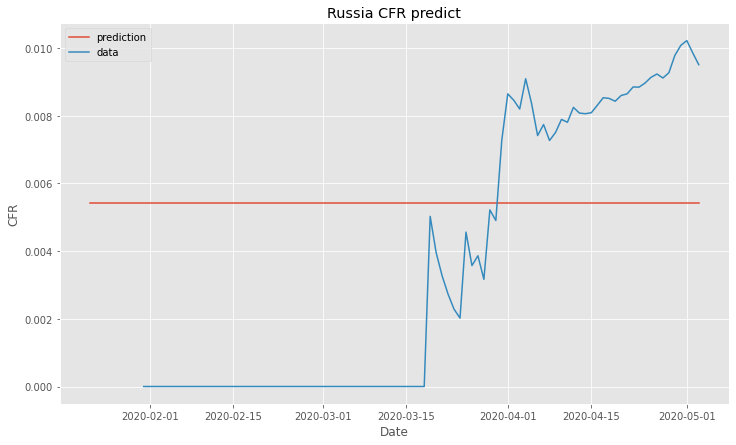

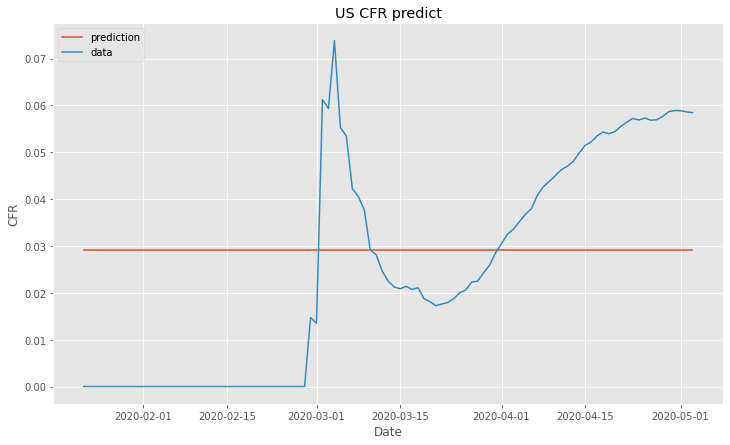

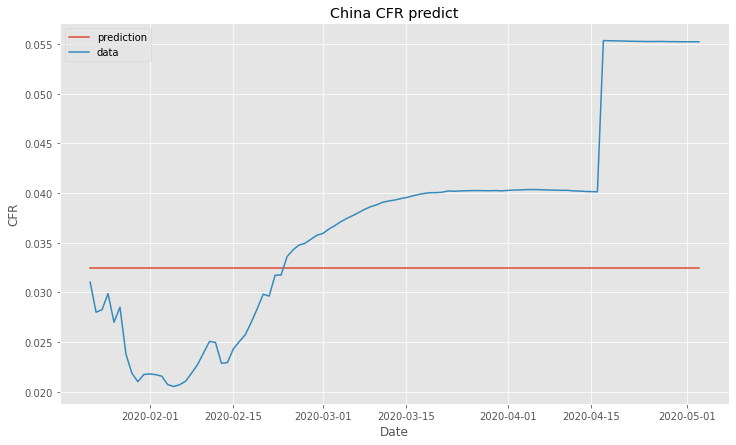

In [ ]:
for country in countries:
    tr=train
    tr=tr.replace([np.inf, -np.inf], np.nan)
    tr[country].dropna(inplace = True) #уберем Nan
    log=country+'Log'
    mean=country+'Mean'
    train[mean] = np.exp(tr[log].mean())
    test[mean] = np.exp(tr[log].mean())
    data=pd.concat([train,test])
    dfRMSEComplite(country, 0, "Mean", np.exp(tr[log].mean()), test[mean], test[country])
    visual(country,'Date', 'CFR', data.Date, data[mean], data[country])
  
  

In [ ]:
dfResults.head() 

Model  RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast  ChinaRMSE
0  Mean        0.005414    0.003597  ... 0.026485       0.032428   0.020825

[1 rows x 7 columns]

#### 2.2 Линейная модель (Linear Trend Model) 

In [ ]:
train["timeIndex"] = ((train.Date - data.Date.min())/np.timedelta64(1, 'D')).round(0).astype(int)
data["timeIndex"] = ((data.Date - data.Date.min())/np.timedelta64(1, 'D')).round(0).astype(int)
test["timeIndex"] = ((test.Date - data.Date.min())/np.timedelta64(1, 'D')).round(0).astype(int)

4.08930075229116
2.5495689022879247
3.2604805843413045


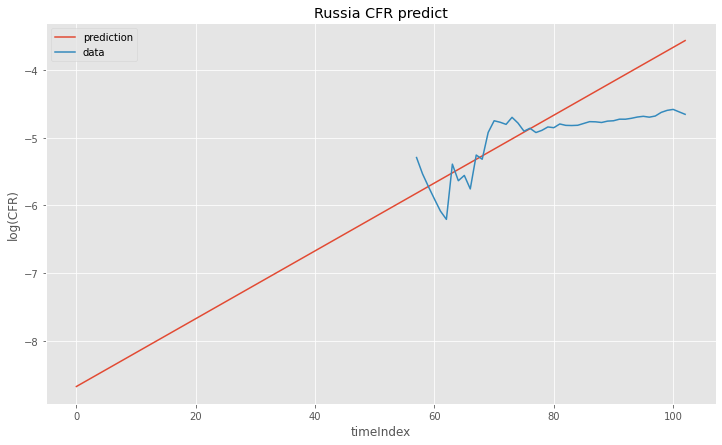

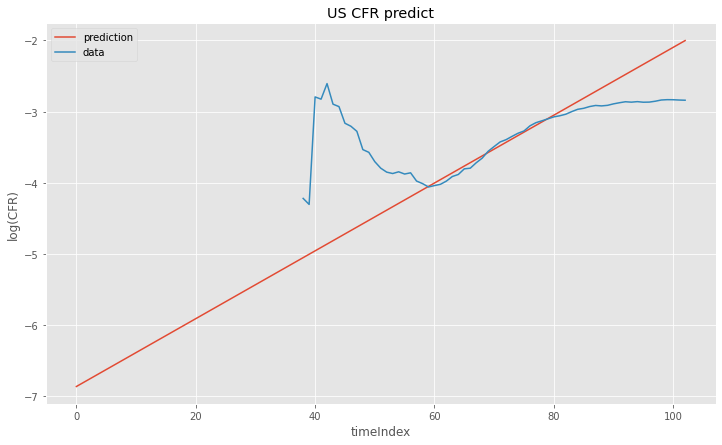

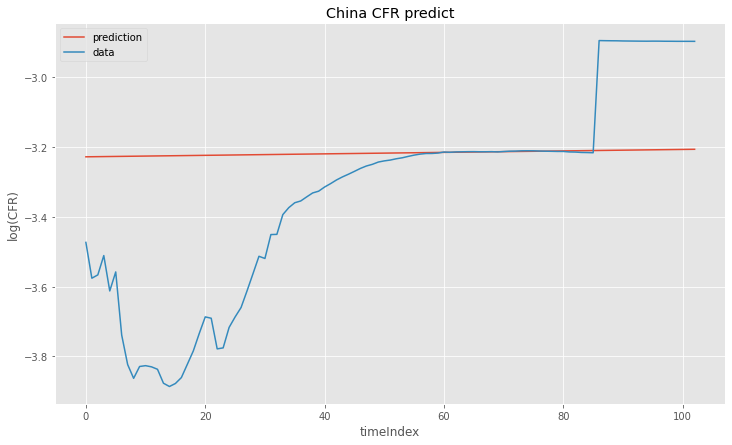

In [ ]:
for country in countries:
    log=country+"Log"
    text=country+"Log ~ timeIndex" 
    tr=train
    tr=tr.replace([np.inf, -np.inf], np.nan)
    tr.dropna(inplace = True)
    model_linear = smf.ols(text, data = tr).fit()   
    model_linear_pred = model_linear.predict(data.timeIndex)
    test_pred = model_linear.predict(data.timeIndex)
    dfRMSEComplite(country, 1, "Linear", "Linear", test_pred, test[country])
    visual(country,'timeIndex', 'log(CFR)', data.timeIndex, model_linear_pred, data[log])

In [ ]:
dfResults.loc[1,"Model"] = "Linear"
dfResults.head() 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0    Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1  Linear         Linear    4.089301  ... 2.549569         Linear  3.260481

[2 rows x 7 columns]

По данным двум моделям можно сказать, что предсказание среднего в данном случае значительно лучше работает.

#### 2.3 Экспоненциальное сглаживание (Exponential smoothing)

Попробуйте так же применить Double exponential smoothing или Triple exponential smoothing.

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

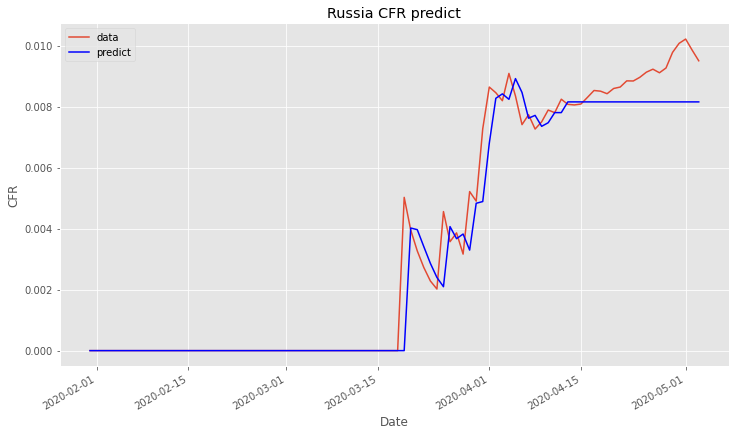

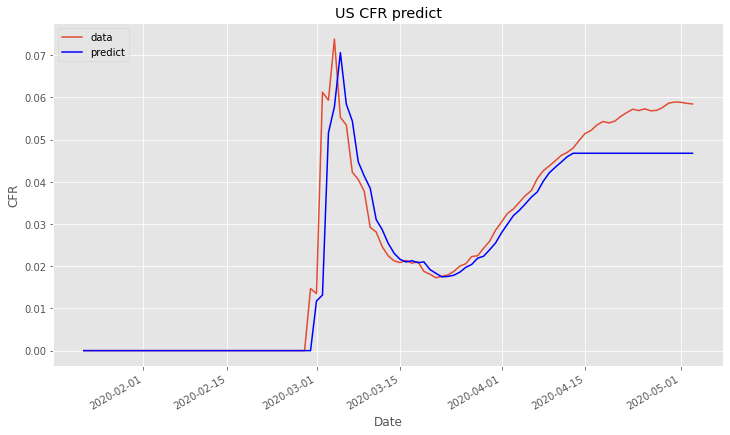

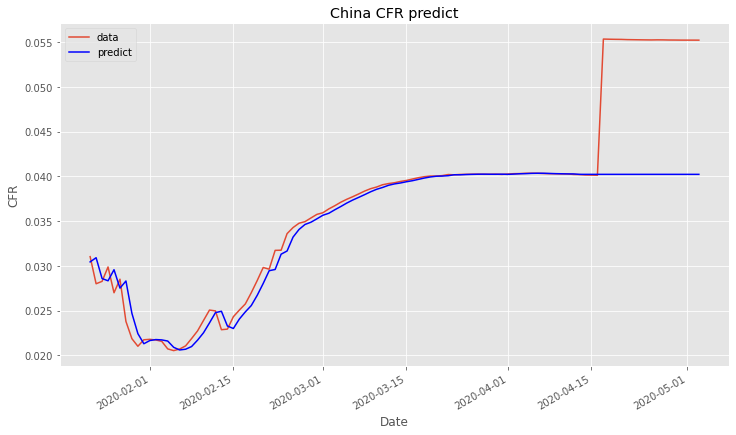

In [ ]:
for country in countries:
    tr=train
    tr=tr.replace([np.inf, -np.inf], np.nan)
    tr[country].dropna(inplace = True)
    model = SimpleExpSmoothing(tr[country])
    fit1 = model.fit(smoothing_level=0.8)
    pred1 = fit1.forecast(test.shape[0])
    plt.figure(figsize=(12, 7))
    plt.title(country+' CFR predict')
    plt.ylabel('CFR')
    plt.xlabel('Date')
    d=pd.concat([tr,test])
    plt.plot(d.Date, d[country], label='data')
    pred=fit1.fittedvalues
    pred1=fit1.predict(test.index[0], np.max(test.index))
    pred=pred.append(pred1)
    pred.plot(color='b', label='predict')
    plt.legend(loc='upper left')
    fore=country+'Forecast'
    rmse=country+'RMSE'
    dfResults.loc[2,"Model"] = "ES"
    dfResults.loc[2,fore] = "SES"
    dfResults.loc[2,rmse] = RMSE(pred1, test[country])


Double exponential smoothing модель Holt

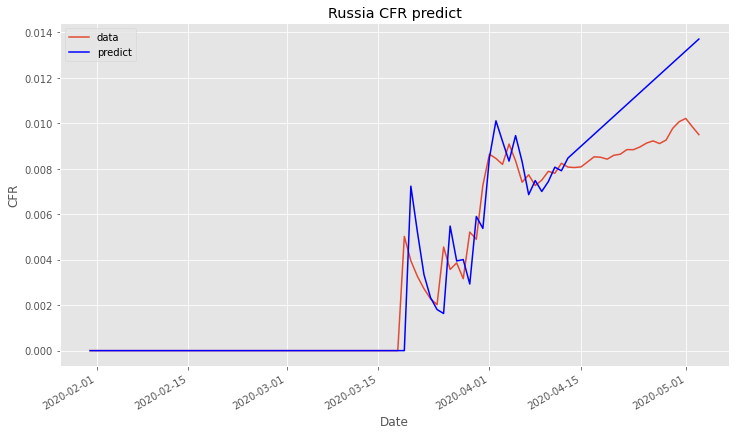

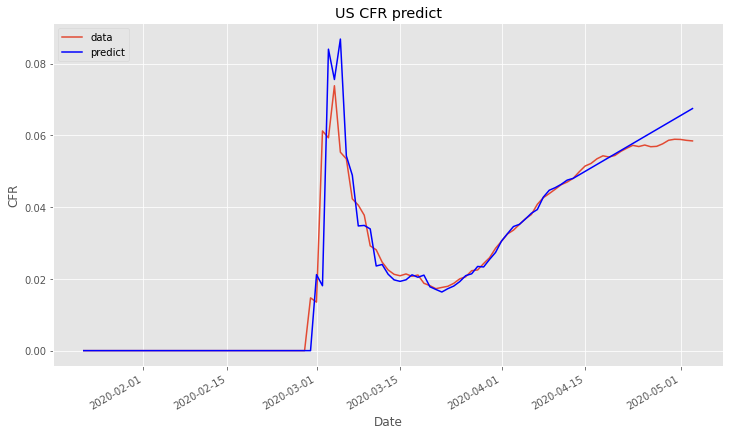

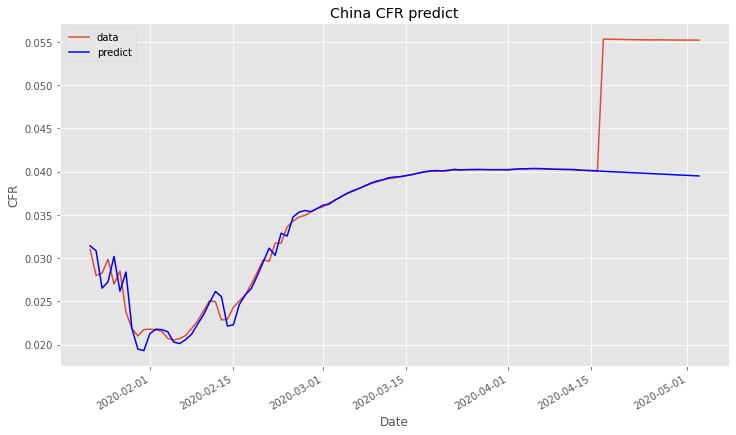

In [ ]:
for country in countries:
    tr=train
    tr=tr.replace([np.inf, -np.inf], np.nan)
    tr[country].dropna(inplace = True)
    model = Holt(tr[country])
    fit1 = model.fit(smoothing_level=0.9, smoothing_slope=0.6)
    plt.figure(figsize=(12, 7))
    plt.title(country+' CFR predict')
    plt.ylabel('CFR')
    plt.xlabel('Date')
    d=pd.concat([tr,test])
    plt.plot(d.Date, d[country], label='data')
    pred=fit1.fittedvalues
    pred1=fit1.predict(test.index[0], np.max(test.index))
    pred=pred.append(pred1)
    pred.plot(color='b', label='predict')
    plt.legend(loc='upper left')
    fore=country+'Forecast'
    rmse=country+'RMSE'
    dfResults.loc[3,"Model"] = "Holt"
    dfResults.loc[3,fore] = "Holt"
    dfResults.loc[3,rmse] = RMSE(pred1, test[country])

In [ ]:
dfResults.head() 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0    Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1  Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2      ES            SES    0.001021  ... 0.009255            SES  0.013536
3    Holt           Holt    0.002360  ... 0.003927           Holt  0.013936

[4 rows x 7 columns]

SES и Holt на разных данных ведут себя по разному в некоторых случаях лучше одно, в некоторых другое, но и то, и то лучше предсказания средним и линейной модели.

#### 2.4 Скользящее среднее (MA - Moving average)

Поэксперементируйте с гиперпараметрами модели.

In [ ]:
import statsmodels.tsa.api as tsa

In [ ]:
#функция предсказания для моделей ARIMA
def arimaModels(country, model, num, name, name2, log):
    fit = model.fit()
    fc, b, t= fit.forecast(test.shape[0])
    predictions_train = pd.Series(fit.fittedvalues, copy=True)
    predictions_train_cumsum = predictions_train.cumsum()
    predictions_train_log = pd.Series(train[log], index=train.index)
    predictions_train_log = predictions_train_log.add(predictions_train_cumsum, fill_value=0)
    predictions_test = pd.Series(fc, copy=True)
    predictions_test_cumsum = predictions_test.cumsum()
    predictions_test_log = pd.Series(train[log][np.max(train.index)], index=predictions_test_cumsum.index)
    predictions_test_log = predictions_test_log.add(predictions_test_cumsum, fill_value=0)
    predictions = pd.concat([predictions_train_log,  predictions_test_log])
    
    dfRMSEComplite(country, num, name, name2, np.exp(predictions_test_log), np.array(test[country]))
    visual(country,'Date', 'CFR', data.Date, np.exp(predictions), data[country])



In [ ]:
#представление данных как разности
for country in countries:
    log=country+"Log"
    sh=country+"Shift"
    diff=country+"Diff"
    train[sh] = train[log].shift()
    test[sh] = test[log].shift()
    data[sh] = data[log].shift()
    train[diff] = train[log] - train[sh]
    test[diff] = test[log] - test[sh]
    data[diff] = data[log] - data[sh]

0.0018988660653240419
0.011656721288075277
0.012091989468382261


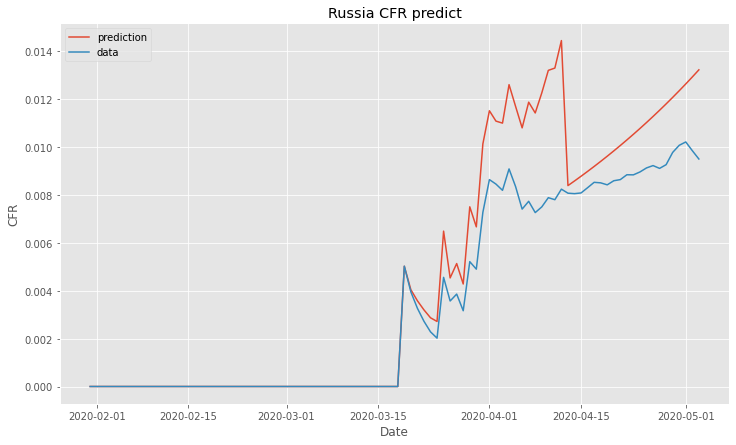

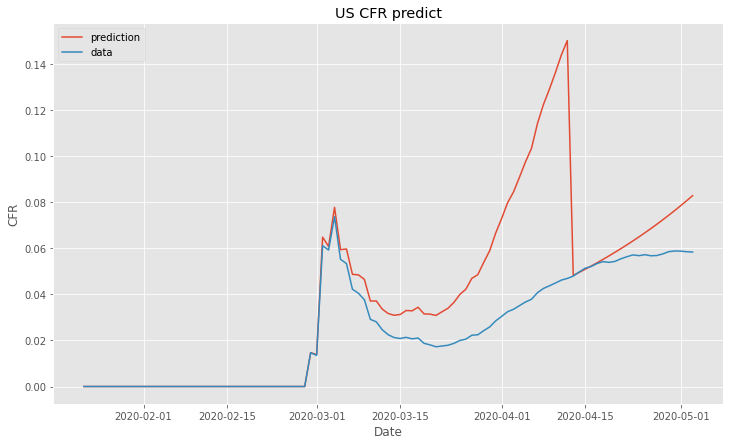

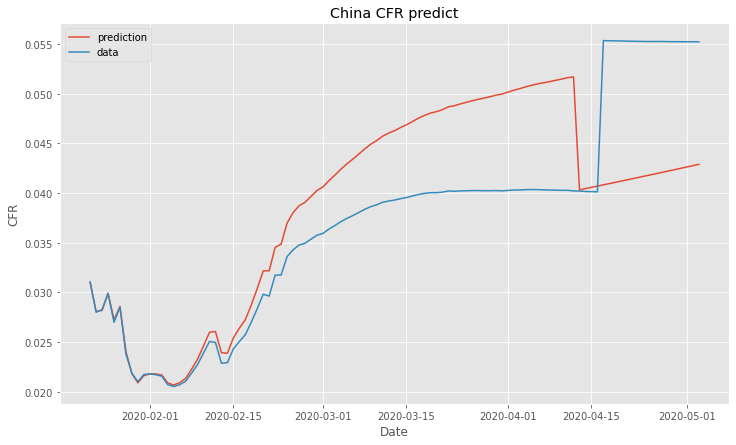

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = tsa.ARMA(tr_diff, order =(0,1))
    arimaModels(country, model, 4, "MA", "MA1", log)

0.0014633868877320145
0.033921938520151504
0.012345227149106212


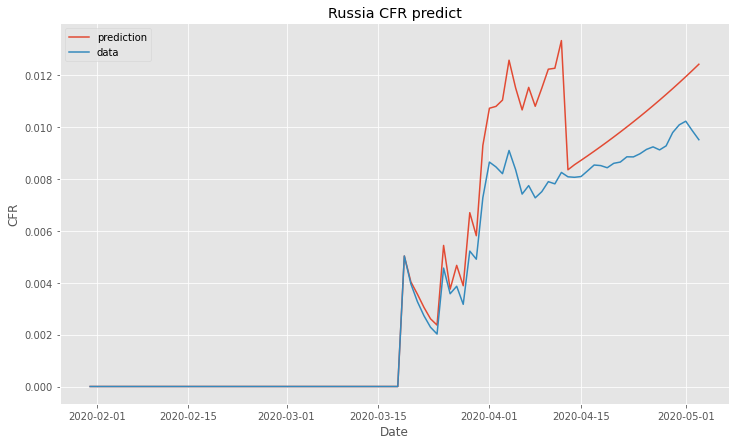

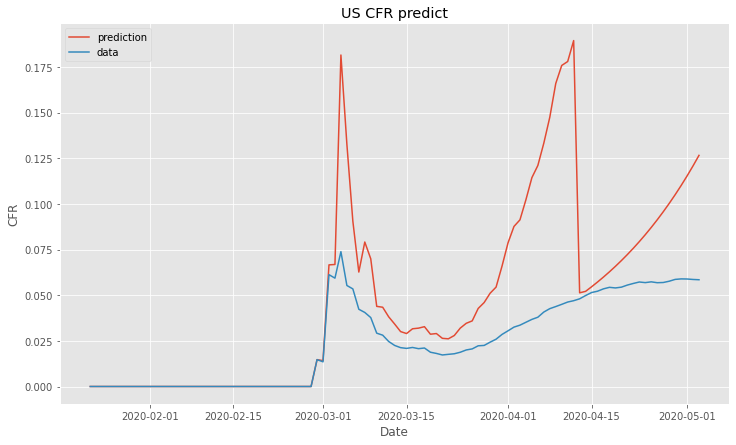

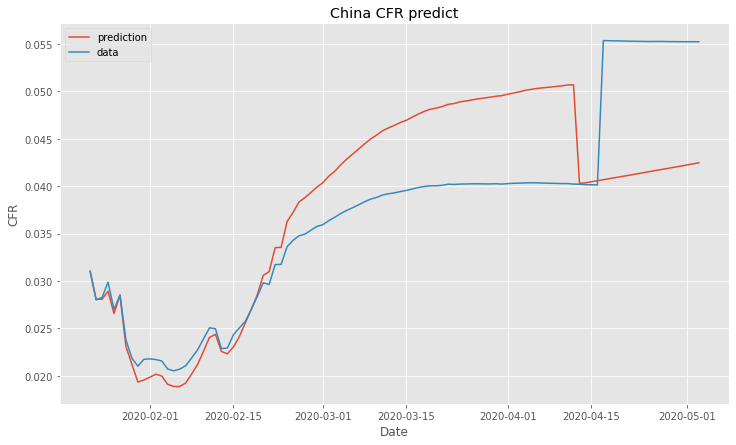

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = tsa.ARMA(tr_diff, order =(0,2))
    arimaModels(country, model, 5, "MA", "MA2", log)

In [ ]:
dfResults.head(10) 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0    Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1  Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2      ES            SES    0.001021  ... 0.009255            SES  0.013536
3    Holt           Holt    0.002360  ... 0.003927           Holt  0.013936
4      MA            MA1    0.001899  ... 0.011657            MA1  0.012092
5      MA            MA2    0.001463  ... 0.033922            MA2  0.012345

[6 rows x 7 columns]

МА показала неплохой результат. При изменении параметров прогнозы на разных данных ведут себя по разному. Значительно ухудшился результат для США.

#### 2.5 Авторегрессионная модель (AR - Autoregressive model)

Поэксперементируйте с гиперпараметрами модели.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

0.002048374985805813
0.02430701327509259
0.012424268151720382


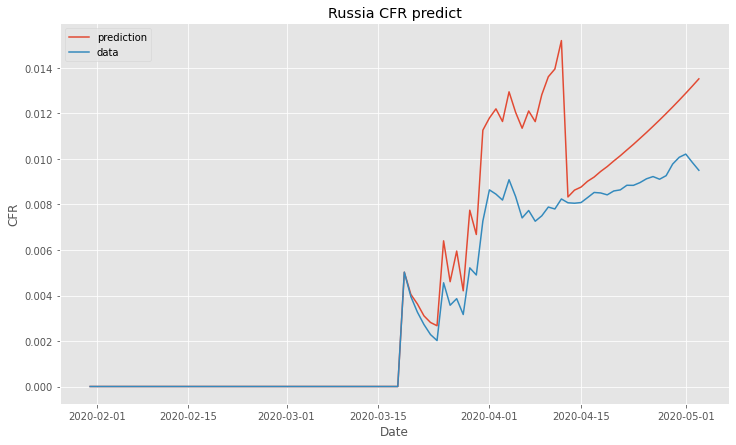

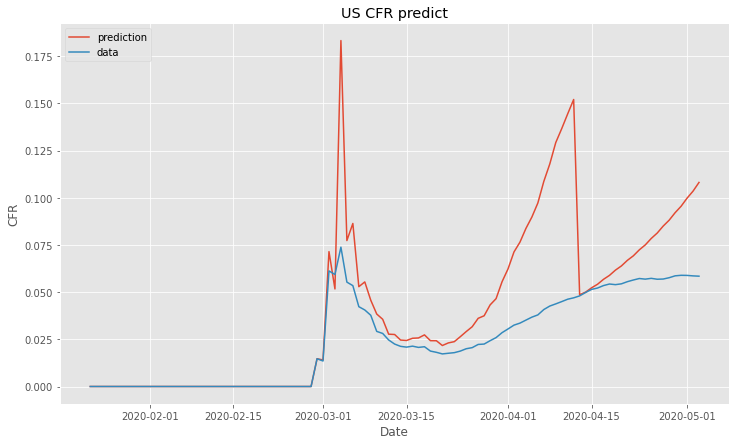

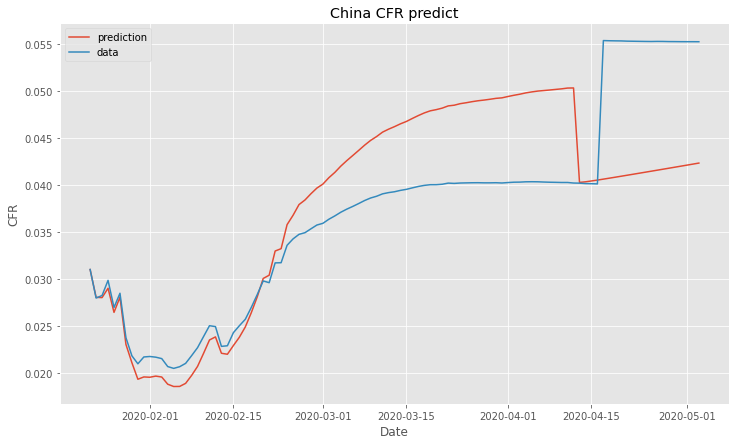

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = ARIMA(tr_diff, order=(3,0,0))
    arimaModels(country, model, 6, "AR", "AR3", log)

0.0018330885104262235
0.011748756571143774
0.012140324606153772


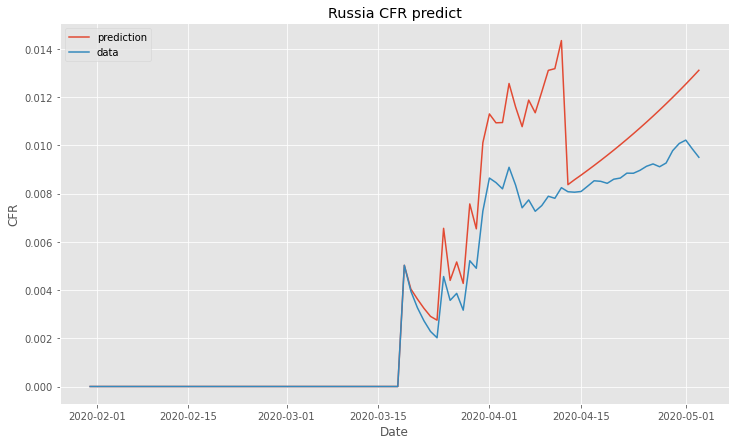

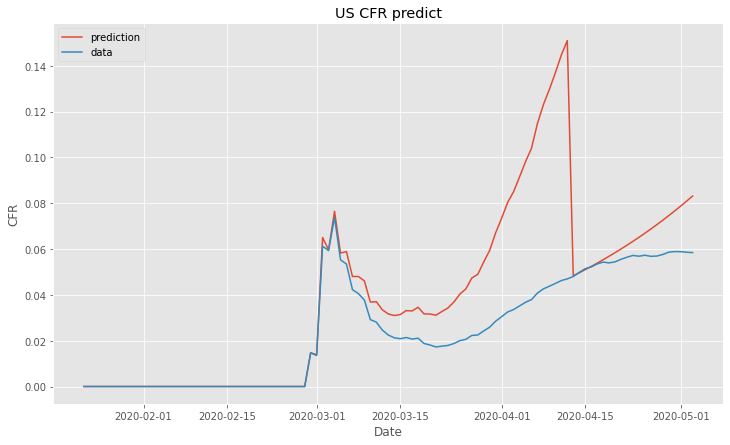

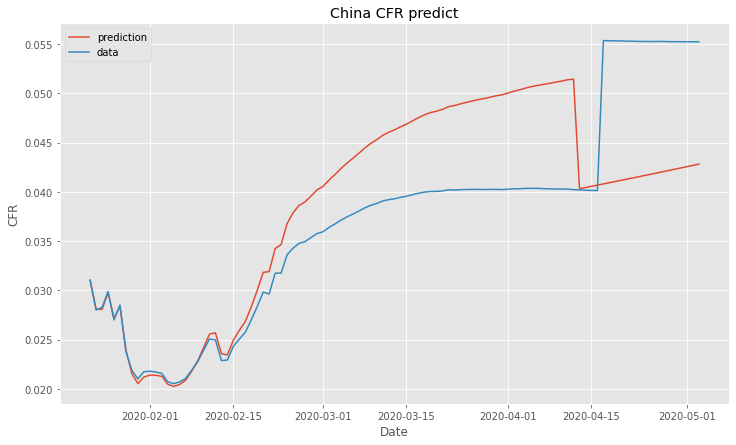

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = ARIMA(tr_diff, order=(1,0,0))
    arimaModels(country, model, 7, "AR", "AR1", log)

In [ ]:
dfResults.head(10) 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0    Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1  Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2      ES            SES    0.001021  ... 0.009255            SES  0.013536
3    Holt           Holt    0.002360  ... 0.003927           Holt  0.013936
4      MA            MA1    0.001899  ... 0.011657            MA1  0.012092
5      MA            MA2    0.001463  ... 0.033922            MA2  0.012345
6      AR            AR3    0.002048  ... 0.024307            AR3  0.012424
7      AR            AR1    0.001833  ... 0.011749            AR1  0.012140

[8 rows x 7 columns]

По полученным на данный момент результатам можно сказать, что лучше задавать меньшие значение параметров.

#### 2.6 ARMA

Поэксперементируйте с гиперпараметрами модели.

0.006169635964207903
0.008819058363286869
0.012396758844339453


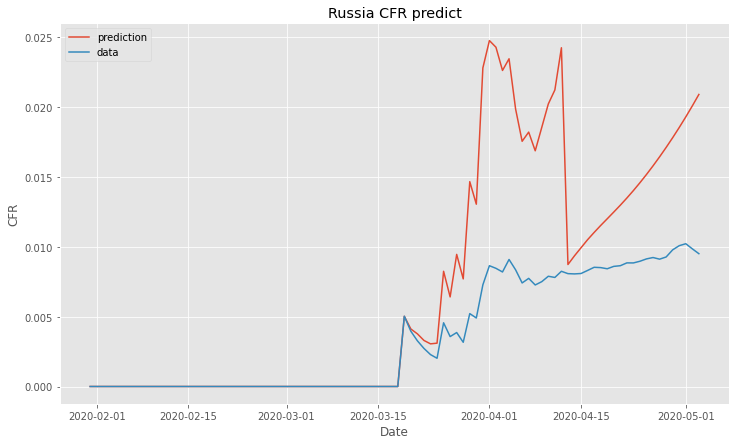

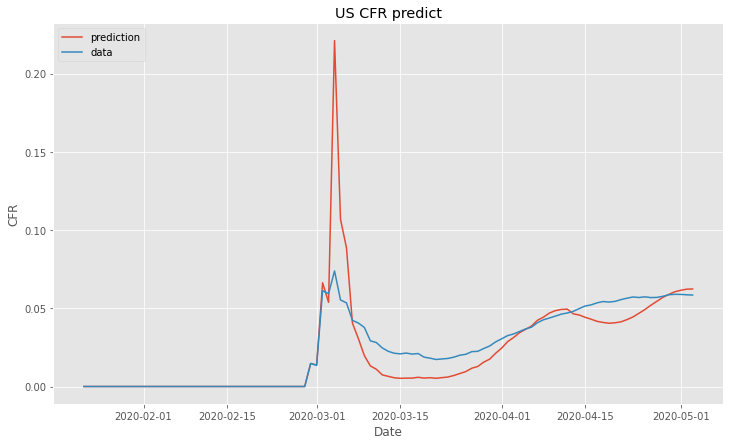

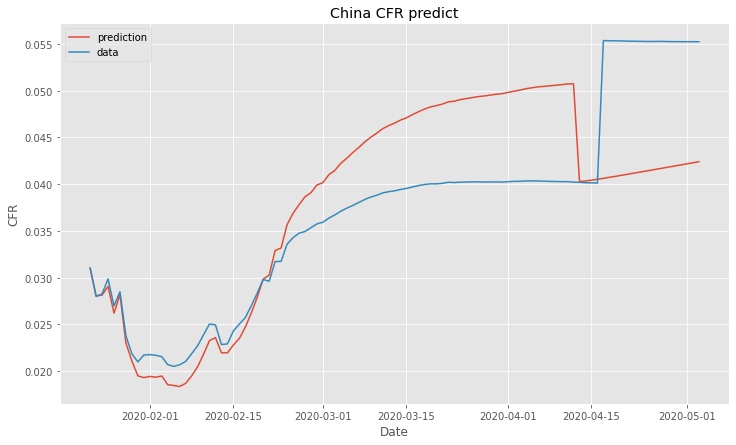

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = tsa.ARMA(tr_diff, order =(3,1))
    arimaModels(country, model, 8, "ARMA", "ARMA(3,1)",log)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


0.0013477992211656767


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


0.024631391089128336
0.01416478027219877


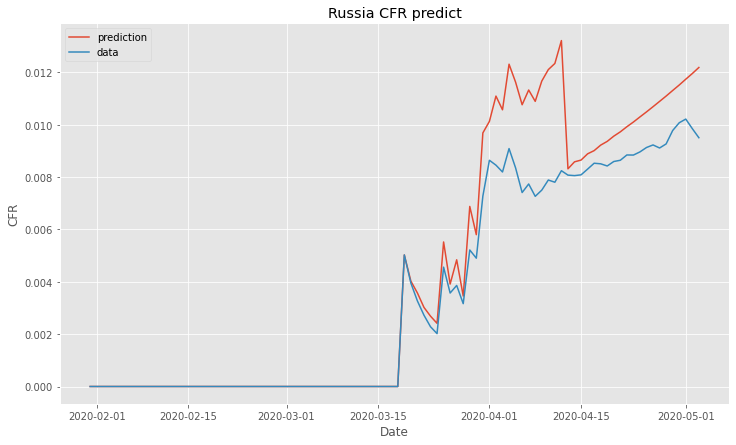

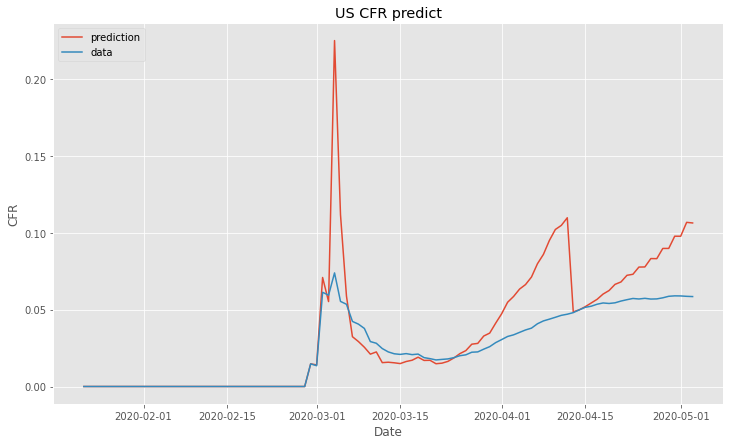

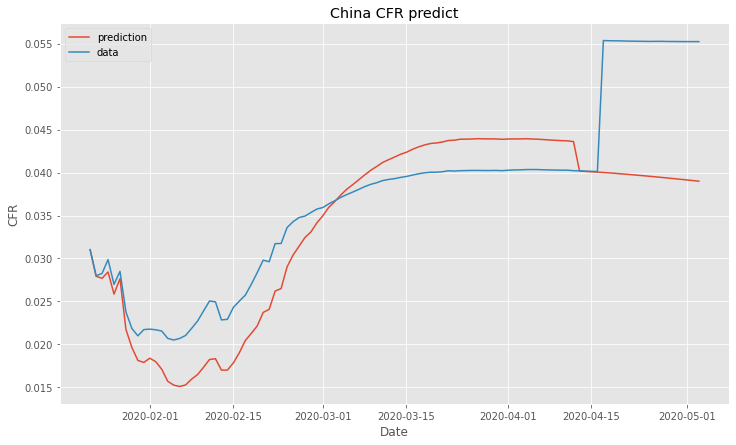

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = tsa.ARMA(tr_diff, order =(5,1))
    arimaModels(country, model, 9, "ARMA", "ARMA(5,1)",log)

In [ ]:
dfResults.head(10) 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0    Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1  Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2      ES            SES    0.001021  ... 0.009255            SES  0.013536
3    Holt           Holt    0.002360  ... 0.003927           Holt  0.013936
4      MA            MA1    0.001899  ... 0.011657            MA1  0.012092
5      MA            MA2    0.001463  ... 0.033922            MA2  0.012345
6      AR            AR3    0.002048  ... 0.024307            AR3  0.012424
7      AR            AR1    0.001833  ... 0.011749            AR1  0.012140
8    ARMA      ARMA(3,1)    0.006170  ... 0.008819      ARMA(3,1)  0.012397
9    ARMA      ARMA(5,1)    0.001348  ... 0.024631      ARMA(5,1)  0.014165

[10 rows x 7 columns]

ARMA(3,1) оказалась удачной для США. Можно заметить, что для России результаты изменяются с точностью наоборот по отношению к другим странам.

#### 2.7 Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average)

0.03591934747077934
0.035558114585056415
0.010912630434231721


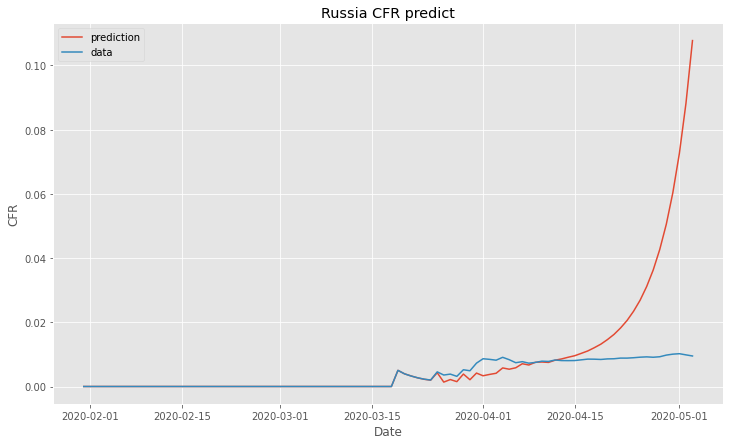

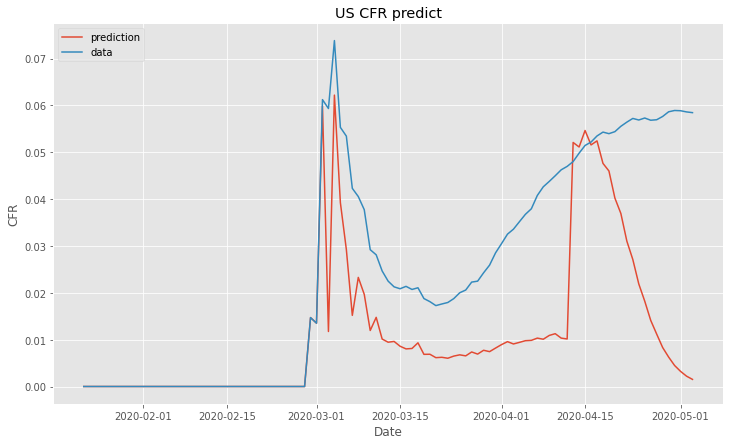

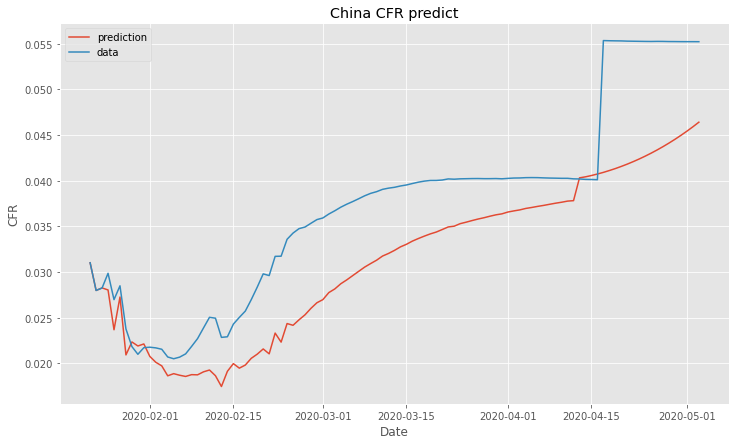

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = ARIMA(tr_diff, order=(3,1,2))
    arimaModels(country, model, 10, "ARIMA", "ARIMA(3,1,2)", log)

0.02871066668385355
0.03881049023985158
0.010970687069396245


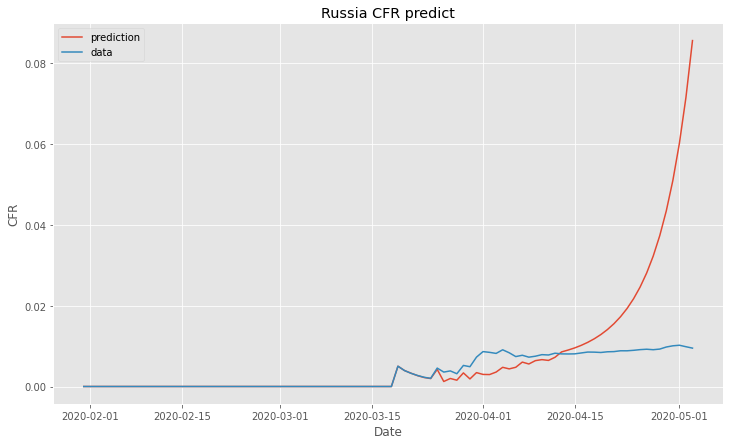

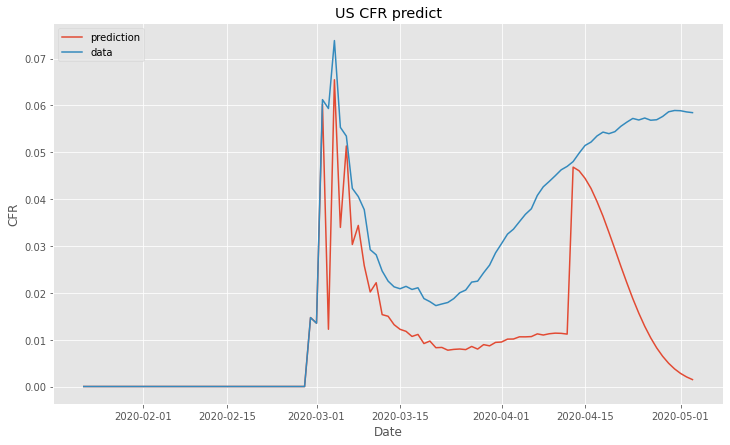

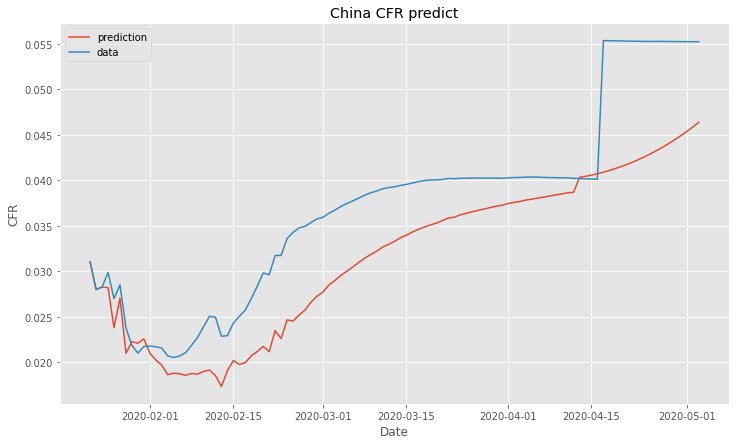

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = ARIMA(tr_diff, order=(1,1,1))
    arimaModels(country, model, 11, "ARIMA", "ARIMA(1,1,1)", log)

In [ ]:
dfResults.head(20) 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0     Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1   Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2       ES            SES    0.001021  ... 0.009255            SES  0.013536
3     Holt           Holt    0.002360  ... 0.003927           Holt  0.013936
4       MA            MA1    0.001899  ... 0.011657            MA1  0.012092
5       MA            MA2    0.001463  ... 0.033922            MA2  0.012345
6       AR            AR3    0.002048  ... 0.024307            AR3  0.012424
7       AR            AR1    0.001833  ... 0.011749            AR1  0.012140
8     ARMA      ARMA(3,1)    0.006170  ... 0.008819      ARMA(3,1)  0.012397
9     ARMA      ARMA(5,1)    0.001348  ... 0.024631      ARMA(5,1)  0.014165
10   ARIMA   ARIMA(3,1,2)    0.035919  ... 0.035558   ARIMA(3,1,2)  0.010913
11   ARIMA   ARIMA(1,1,1)    0.028711  ... 0.038810   ARIMA(1,1,1)  0.010971

[12 rows x 7 columns]

Очень сложно подобрать подходящие параметры для ARIMA. Результаты на данной модели получились значительно хуже, чем ожидалось.

2.8 SARIMA

0.004069372449902077
0.008356380525662127
0.012414688232698484


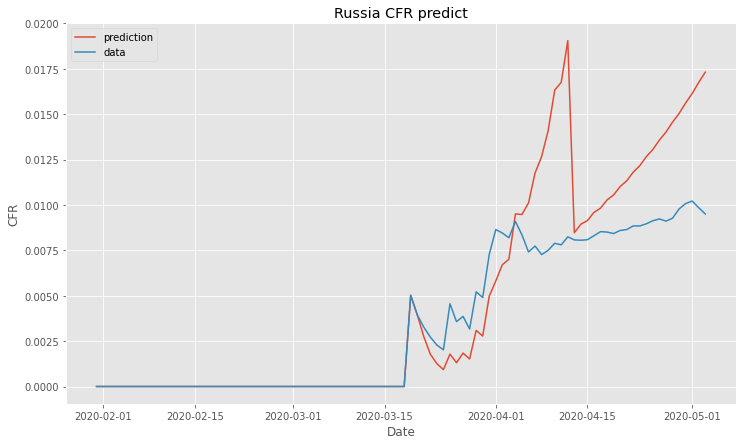

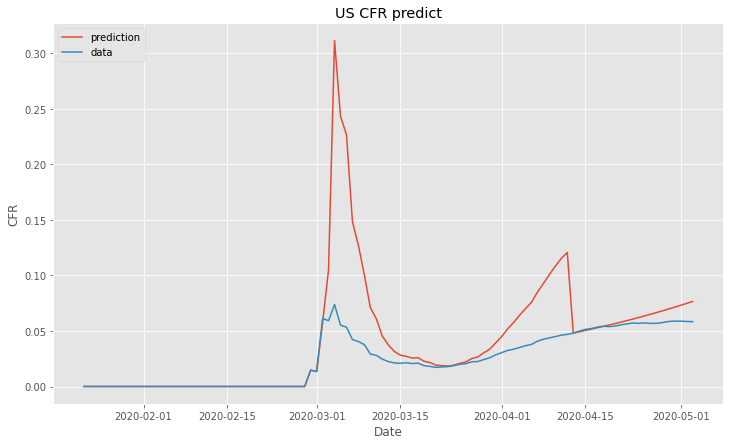

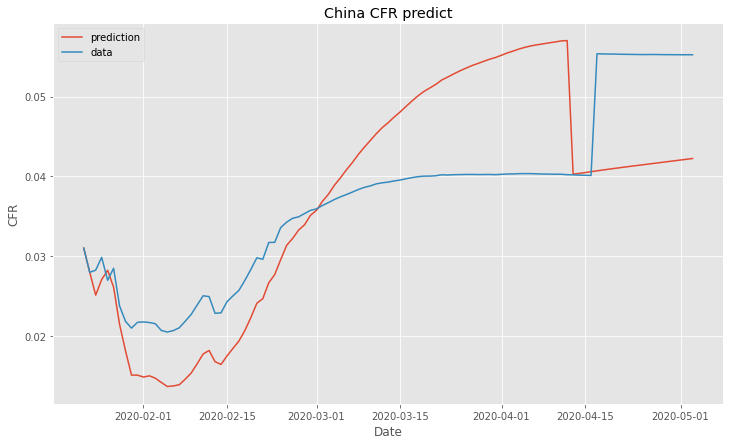

In [ ]:
for country in countries:
    log, tr_diff, d_diff = dataPrep(country)
    model = sm.tsa.statespace.SARIMAX(tr_diff,
                                order=(2, 1, 1),
                                seasonal_order=(1, 0, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    fit = model.fit()
    fc= fit.forecast(test.shape[0])
    
    predictions_train = pd.Series(fit.fittedvalues, copy=True)
    predictions_train_cumsum = predictions_train.cumsum()
    predictions_train_log = pd.Series(train[log], index=train.index)
    predictions_train_log = predictions_train_log.add(predictions_train_cumsum, fill_value=0)
    predictions_test = pd.Series(fc, copy=True)
    predictions_test_cumsum = predictions_test.cumsum()
    predictions_test_log = pd.Series(train[log][np.max(train.index)], index=predictions_test_cumsum.index)
    predictions_test_log = predictions_test_log.add(predictions_test_cumsum, fill_value=0)
    predictions = pd.concat([predictions_train_log,  predictions_test_log])
    

    dfRMSEComplite(country, 12, "SARIMA", "SARIMA", np.exp(predictions_test_log), np.array(test[country]))
    visual(country,'Date', 'CFR', data.Date, np.exp(predictions), data[country])
  

In [ ]:
dfResults.head(20) 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0     Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1   Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2       ES            SES    0.001021  ... 0.009255            SES  0.013536
3     Holt           Holt    0.002360  ... 0.003927           Holt  0.013936
4       MA            MA1    0.001899  ... 0.011657            MA1  0.012092
5       MA            MA2    0.001463  ... 0.033922            MA2  0.012345
6       AR            AR3    0.002048  ... 0.024307            AR3  0.012424
7       AR            AR1    0.001833  ... 0.011749            AR1  0.012140
8     ARMA      ARMA(3,1)    0.006170  ... 0.008819      ARMA(3,1)  0.012397
9     ARMA      ARMA(5,1)    0.001348  ... 0.024631      ARMA(5,1)  0.014165
10   ARIMA   ARIMA(3,1,2)    0.035919  ... 0.035558   ARIMA(3,1,2)  0.010913
11   ARIMA   ARIMA(1,1,1)    0.028711  ... 0.038810   ARIMA(1,1,1)  0.010971
12  SARIMA         SARIMA    0.004069  ... 0.008356         SARIMA  0.012415

[13 rows x 7 columns]

Несмотря на отсутствие сезонности SARIMA показала очень неплохой результат, который превзошел результат на модели ARIMA.

#### 2.9 Библиотека Prophet
Попробуйте использовать библиотеку Prophet для предсказания временного ряда. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).


In [ ]:
from fbprophet import Prophet

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.0012905869476485025


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.008784977990984023
0.012761892082472316


<Figure size 864x504 with 0 Axes>

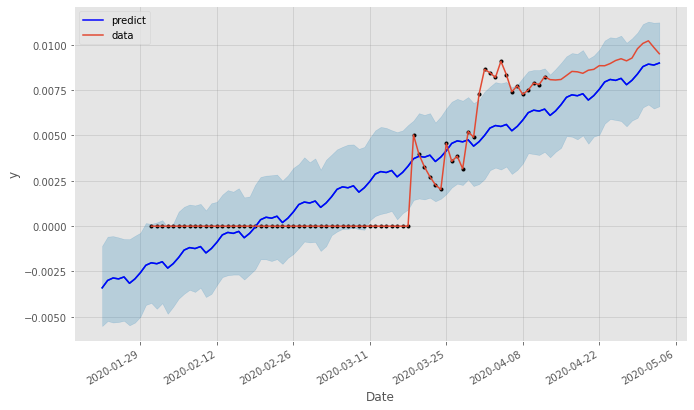

<Figure size 864x504 with 0 Axes>

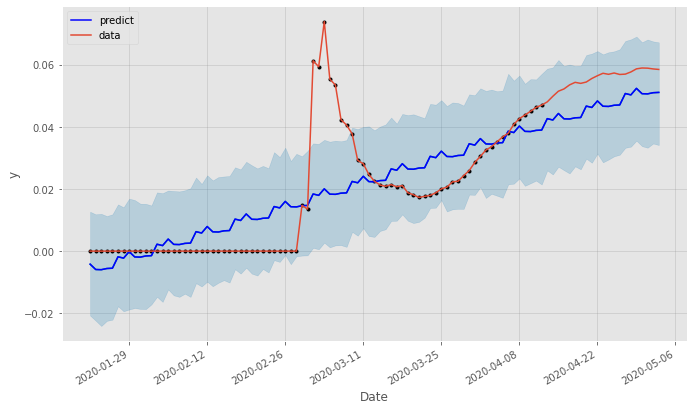

<Figure size 864x504 with 0 Axes>

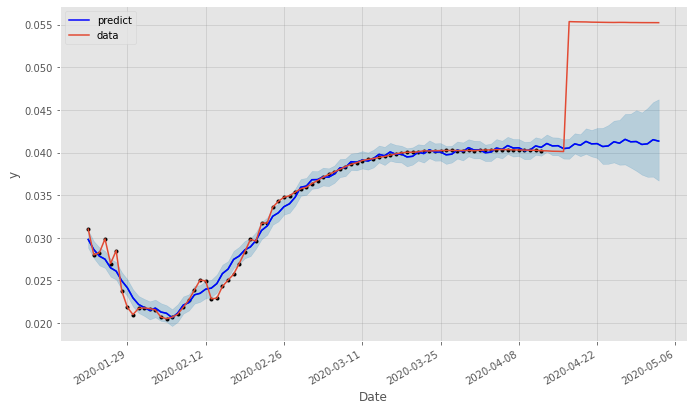

In [ ]:
for country in countries:
    m = Prophet()
    tr=pd.DataFrame(columns=['ds', 'y'])
    tr["ds"]=train["Date"]
    tr["y"]=train[country]
    plt.figure(figsize=(12, 7))
    fit2=m.fit(tr)
    future = m.make_future_dataframe(periods=test.shape[0])
    forecast = m.predict(future)

    fore=country+'Forecast'
    rmse=country+'RMSE'
    mse = (np.array(forecast.yhat[train.shape[0]:]) - np.array(test[country]))**2
    res = np.sqrt(mse.sum()/len(mse))
    print(res)
    dfResults.loc[13,fore] = "Prophet"
    dfResults.loc[13,rmse] = res
    dfResults.loc[13,"Model"] = "Prophet"
    m.plot(forecast)
    plt.plot(data.Date,forecast.yhat, color="blue",label="predict")
    data[country].plot(label="data")
    plt.legend(loc='upper left')

In [ ]:
dfResults.head(20) 

Model RussiaForecast  RussiaRMSE  ...   USRMSE  ChinaForecast ChinaRMSE
0      Mean       0.005414    0.003597  ... 0.026485       0.032428  0.020825
1    Linear         Linear    4.089301  ... 2.549569         Linear  3.260481
2        ES            SES    0.001021  ... 0.009255            SES  0.013536
3      Holt           Holt    0.002360  ... 0.003927           Holt  0.013936
4        MA            MA1    0.001899  ... 0.011657            MA1  0.012092
5        MA            MA2    0.001463  ... 0.033922            MA2  0.012345
6        AR            AR3    0.002048  ... 0.024307            AR3  0.012424
7        AR            AR1    0.001833  ... 0.011749            AR1  0.012140
8      ARMA      ARMA(3,1)    0.006170  ... 0.008819      ARMA(3,1)  0.012397
9      ARMA      ARMA(5,1)    0.001348  ... 0.024631      ARMA(5,1)  0.014165
10    ARIMA   ARIMA(3,1,2)    0.035919  ... 0.035558   ARIMA(3,1,2)  0.010913
11    ARIMA   ARIMA(1,1,1)    0.028711  ... 0.038810   ARIMA(1,1,1)  0.010971
12   SARIMA         SARIMA    0.004069  ... 0.008356         SARIMA  0.012415
13  Prophet        Prophet    0.001291  ... 0.008785        Prophet  0.012762

[14 rows x 7 columns]

 Библиотека Prophet оказалась очень удобной в применении и показала очень неплохой результат для всех данных. Возможно ее можно использовать как относительно универсальный способ, при отсутствии свободного времени для подбора параметров других моделей.

#### 2.10 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?

Выбрвнные в первой части работы признаки не изменяются в зависимости от времени и их использование вряд ли даст результат отличающийся от обычной линейной модели. Из данных изменяющиххся во времени у нас есть indexTime, сомнительная идея, но почему бы не попробовать.

0.0016199397426841216
0.042366863837929945
0.01375385862465306


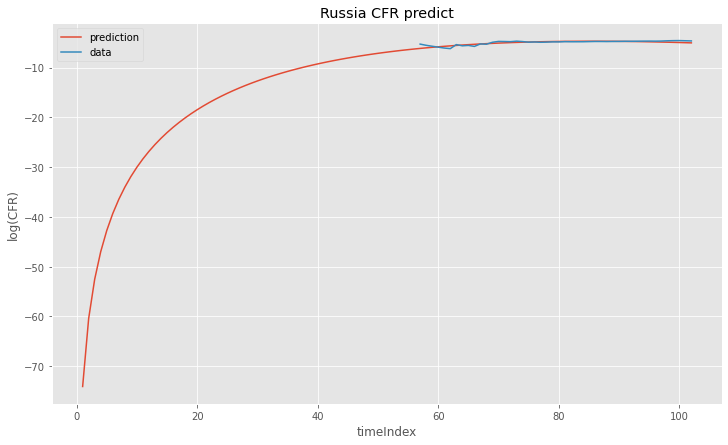

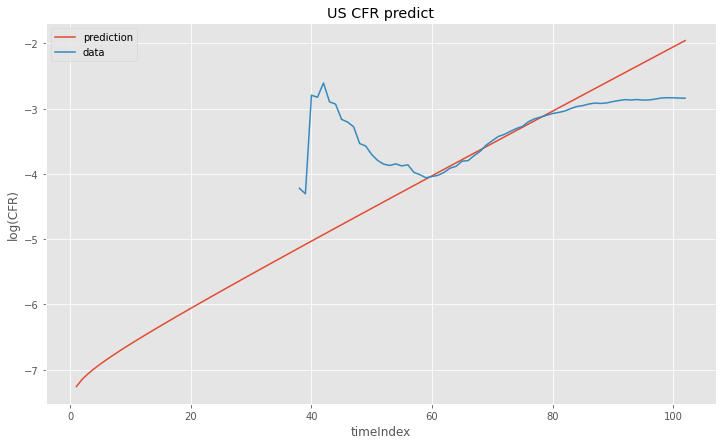

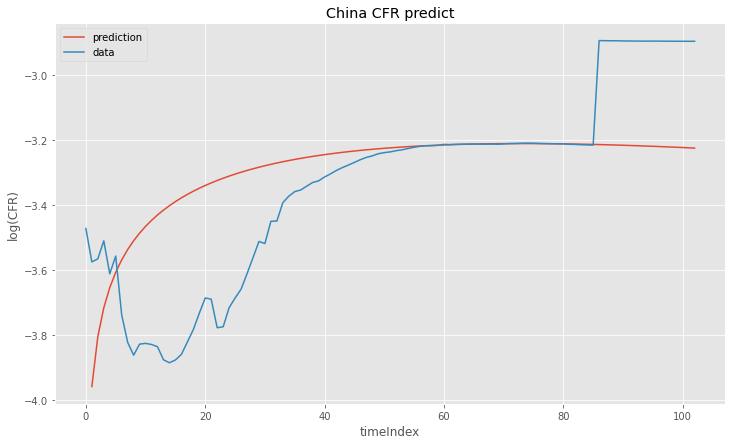

In [ ]:
for country in countries:
    log= country+"Log"
    tr = train
    tr=tr.replace([np.inf, -np.inf], np.nan)
    tr.dropna(inplace = True)
    t="timeIndex"
    text=country+"Log ~ timeIndex + np.log("+t+")"    
    
    model_linear = smf.ols(text, data = tr).fit()   
    model_linear_pred = model_linear.predict(data.timeIndex)
    test_pred = model_linear.predict(test.timeIndex)
    dfRMSEComplite(country, 14, "Linear Regression", "LR(timeIndex)", np.exp(test_pred), test[country])
    visual(country,'timeIndex', 'log(CFR)', data.timeIndex, model_linear_pred, data[log])

In [ ]:
dfResults.head(20) 

Model RussiaForecast  ...  ChinaForecast ChinaRMSE
0                Mean       0.005414  ...       0.032428  0.020825
1              Linear         Linear  ...         Linear  3.260481
2                  ES            SES  ...            SES  0.013536
3                Holt           Holt  ...           Holt  0.013936
4                  MA            MA1  ...            MA1  0.012092
5                  MA            MA2  ...            MA2  0.012345
6                  AR            AR3  ...            AR3  0.012424
7                  AR            AR1  ...            AR1  0.012140
8                ARMA      ARMA(3,1)  ...      ARMA(3,1)  0.012397
9                ARMA      ARMA(5,1)  ...      ARMA(5,1)  0.014165
10              ARIMA   ARIMA(3,1,2)  ...   ARIMA(3,1,2)  0.010913
11              ARIMA   ARIMA(1,1,1)  ...   ARIMA(1,1,1)  0.010971
12             SARIMA         SARIMA  ...         SARIMA  0.012415
13            Prophet        Prophet  ...        Prophet  0.012762
14  Linear Regression  LR(timeIndex)  ...  LR(timeIndex)  0.013754

[15 rows x 7 columns]

Результаты оказались довольно неплохими и уж точно лучше, чем для линейной модели. Ранее на данных других стран получались результаты лучше.

#### 2.11 Выводы

Чем сложнее модель, тем сложнее подбирать к ней параметры, однако простые способы прогнозирования временных рядов не могут дать желаемой точности. Задать большие значения параметров, усложнив модель не значит сделать ее лучше, наоборот чаще всего подобные действия приводят к большим ошибкам.

In [ ]:
dfResults.head(20) 

Model RussiaForecast  ...  ChinaForecast ChinaRMSE
0                Mean       0.005414  ...       0.032428  0.020825
1              Linear         Linear  ...         Linear  3.260481
2                  ES            SES  ...            SES  0.013536
3                Holt           Holt  ...           Holt  0.013936
4                  MA            MA1  ...            MA1  0.012092
5                  MA            MA2  ...            MA2  0.012345
6                  AR            AR3  ...            AR3  0.012424
7                  AR            AR1  ...            AR1  0.012140
8                ARMA      ARMA(3,1)  ...      ARMA(3,1)  0.012397
9                ARMA      ARMA(5,1)  ...      ARMA(5,1)  0.014165
10              ARIMA   ARIMA(3,1,2)  ...   ARIMA(3,1,2)  0.010913
11              ARIMA   ARIMA(1,1,1)  ...   ARIMA(1,1,1)  0.010971
12             SARIMA         SARIMA  ...         SARIMA  0.012415
13            Prophet        Prophet  ...        Prophet  0.012762
14  Linear Regression  LR(timeIndex)  ...  LR(timeIndex)  0.013754

[15 rows x 7 columns]

## Выводы по работе
В данной работе мы работали с временными рядами. Проанализировали имеющиеся данные, сделали екоторые предположения относительно сложившейся ситуации. Сравнили характер распространения вируса в разных странах. Попробовали спрогнозировать развитие ситуации дальше для нескольких крупнейших стран различными способами. Более универсальным и простым мне показался использование библиотеки Prophet. Хотя в теории использование моделей ARMA,ARIMA и SARIMA могут давать очень точные результаты. Возможно недостаточная точность связана с не самыми лучшими для прогнозирования данными (Выбросы в случае Китая, не хватка информации для России).